In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
import numpy as np


In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU devices: []


In [3]:
NUM_WORDS = 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print("Število učnih vzorcev:", len(x_train))
print("Število testnih vzorcev:", len(x_test))
print("Primer surove recenzije (kodirane kot indeksi besed):", x_train[0][:10])


def vectorize_sequences(sequences, dimension=NUM_WORDS):
    results = np.zeros((len(sequences), dimension), dtype="float32")
    for i, seq in enumerate(sequences):
        results[i, np.array(seq)] = 1.0
    return results


x_train_vec = vectorize_sequences(x_train)
x_test_vec = vectorize_sequences(x_test)

print("Oblika vhodne matrike:", x_train_vec.shape)
# print("vektorizirane recenzije:", x_train_vec[0][:20])

y_train = np.asarray(y_train).astype("float32")
y_test = np.asarray(y_test).astype("float32")



Število učnih vzorcev: 25000
Število testnih vzorcev: 25000
Primer surove recenzije (kodirane kot indeksi besed): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Oblika vhodne matrike: (25000, 5000)


In [4]:
# V1.5

from tensorflow.keras import layers, regularizers, optimizers

num_neurons = [4, 16, 512]
regularization_modes = ["none", "l2_first", "l2_both"]
dropout_modes = ["none", "dropout_first", "dropout_both"]
LRs = {
    "Small": 0.0005,
    "Normal": 0.001,
    "Large": 0.002
}

EPOCHS = 20
BATCH_SIZE = 512

l2_strength = 0.001
dropout_rate = 0.5

threshold = 0.005

results = {}


def build_model(n, reg_mode, drop_mode, LR):
    def maybe_l2(apply):
        return regularizers.l2(l2_strength) if apply else None

    def maybe_dropout(apply):
        return layers.Dropout(dropout_rate) if apply else None

    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(NUM_WORDS,)))

    # Prva plast
    model.add(layers.Dense(
        n, activation='relu',
        kernel_regularizer=maybe_l2(reg_mode in ["l2_first", "l2_both"])
    ))
    if drop_mode in ["dropout_first", "dropout_both"]:
        model.add(maybe_dropout(True))

    # Druga plast
    model.add(layers.Dense(
        n, activation='relu',
        kernel_regularizer=maybe_l2(reg_mode == "l2_both")
    ))
    if drop_mode == "dropout_both":
        model.add(maybe_dropout(True))

    # Izhod
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=LR),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


for lr_name, lr_value in LRs.items():
    results[lr_name] = {}
    for drop_mode in dropout_modes:
        results[lr_name][drop_mode] = {}
        for reg_mode in regularization_modes:
            print(f"\n===== Dropout: {drop_mode} | Regularizacija: {reg_mode} | LR: {lr_value} =====")
            results[lr_name][drop_mode][reg_mode] = {}
            for n in num_neurons:
                print(f" → Učenje modela z {n} nevroni ...")
                model = build_model(n, reg_mode, drop_mode, lr_value)

                history = model.fit(
                    x_train_vec, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test_vec, y_test),
                    verbose=0
                )

                val_loss = np.array(history.history['val_loss'])
                best_epoch = np.argmin(val_loss)

                # detekcija platoja
                delta = np.abs(np.diff(val_loss))
                plateau_epoch = None
                for i in range(best_epoch - 1):
                    if delta[i] < threshold and delta[i + 1] < threshold:
                        plateau_epoch = i
                        break

                results[lr_name][drop_mode][reg_mode][n] = {
                    'history': history,
                    'best_epoch': best_epoch,
                    'plateau_epoch': plateau_epoch

                }

print("\n✅ Vsi modeli naučeni!")



===== Dropout: none | Regularizacija: none | LR: 0.0005 =====
 → Učenje modela z 4 nevroni ...
 → Učenje modela z 16 nevroni ...
 → Učenje modela z 512 nevroni ...

===== Dropout: none | Regularizacija: l2_first | LR: 0.0005 =====
 → Učenje modela z 4 nevroni ...
 → Učenje modela z 16 nevroni ...
 → Učenje modela z 512 nevroni ...

===== Dropout: none | Regularizacija: l2_both | LR: 0.0005 =====
 → Učenje modela z 4 nevroni ...
 → Učenje modela z 16 nevroni ...
 → Učenje modela z 512 nevroni ...

===== Dropout: dropout_first | Regularizacija: none | LR: 0.0005 =====
 → Učenje modela z 4 nevroni ...
 → Učenje modela z 16 nevroni ...
 → Učenje modela z 512 nevroni ...

===== Dropout: dropout_first | Regularizacija: l2_first | LR: 0.0005 =====
 → Učenje modela z 4 nevroni ...
 → Učenje modela z 16 nevroni ...
 → Učenje modela z 512 nevroni ...

===== Dropout: dropout_first | Regularizacija: l2_both | LR: 0.0005 =====
 → Učenje modela z 4 nevroni ...
 → Učenje modela z 16 nevroni ...
 → U

In [5]:
for LR in results:
    for dropout_mode in results[LR]:
        for reg_mode in results[LR][dropout_mode]:
            for n in results[LR][dropout_mode][reg_mode]:
                history = results[LR][dropout_mode][reg_mode][n]['history']

                val_loss = np.array(history.history['val_loss'])
                best_epoch = int(np.argmin(val_loss))

                delta = np.abs(np.diff(val_loss))
                plateau_epoch = None
                for i in range(max(0, best_epoch - 1)):
                    if i + 1 < len(delta) and delta[i] < threshold and delta[i + 1] < threshold:
                        plateau_epoch = int(i)
                        break

                results[LR][dropout_mode][reg_mode][n]['best_epoch'] = best_epoch
                results[LR][dropout_mode][reg_mode][n]['plateau_epoch'] = plateau_epoch

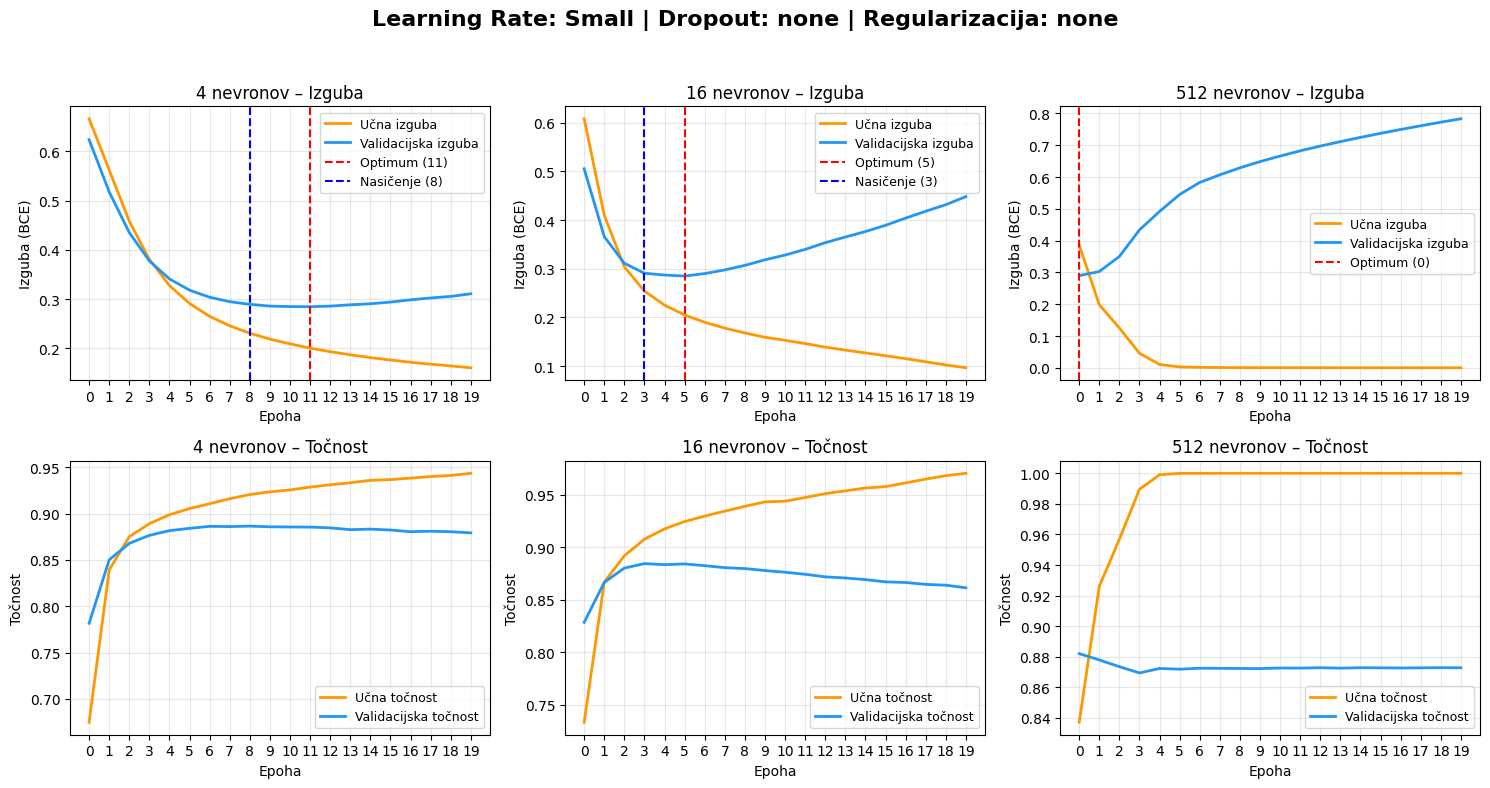

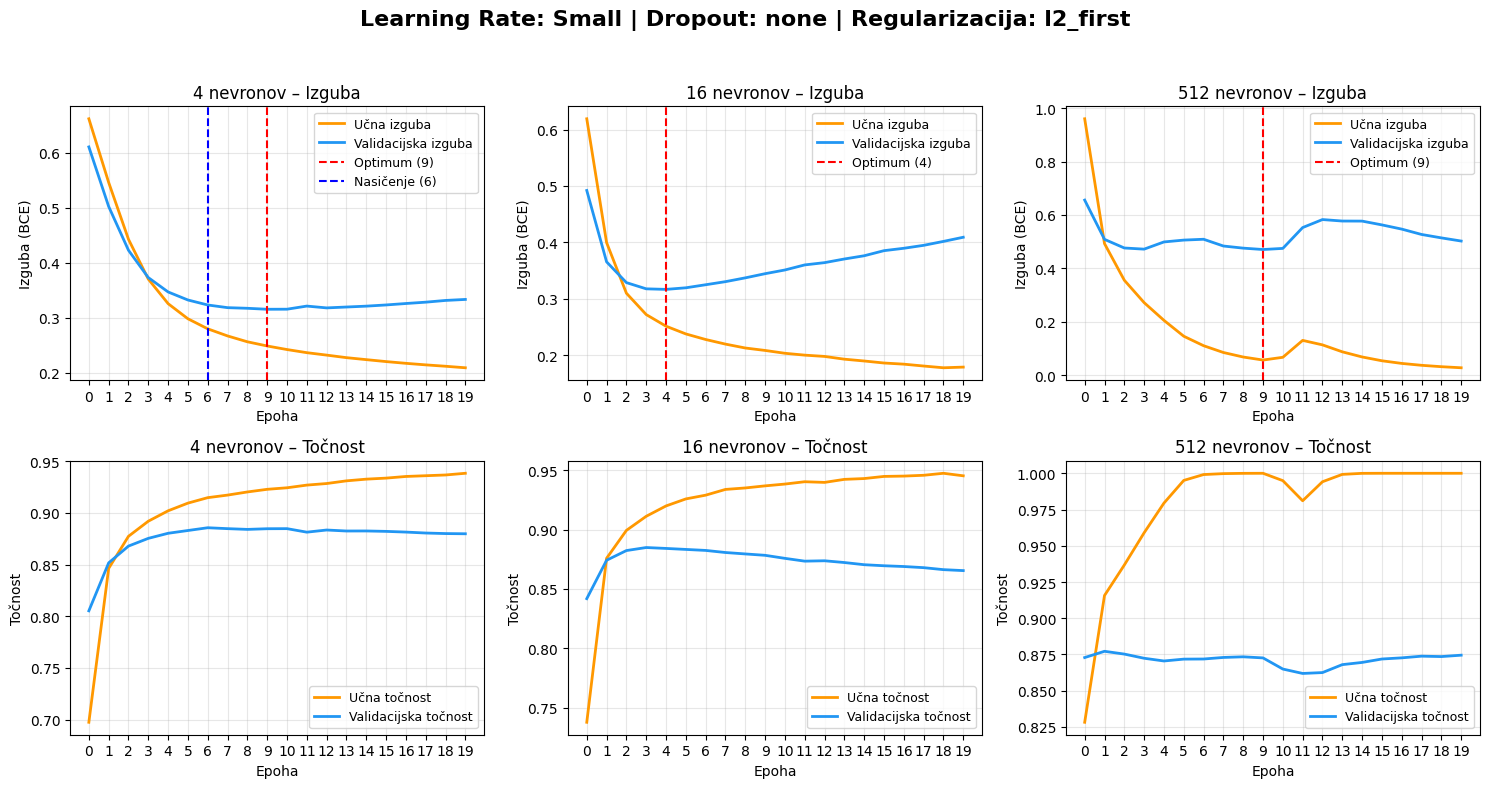

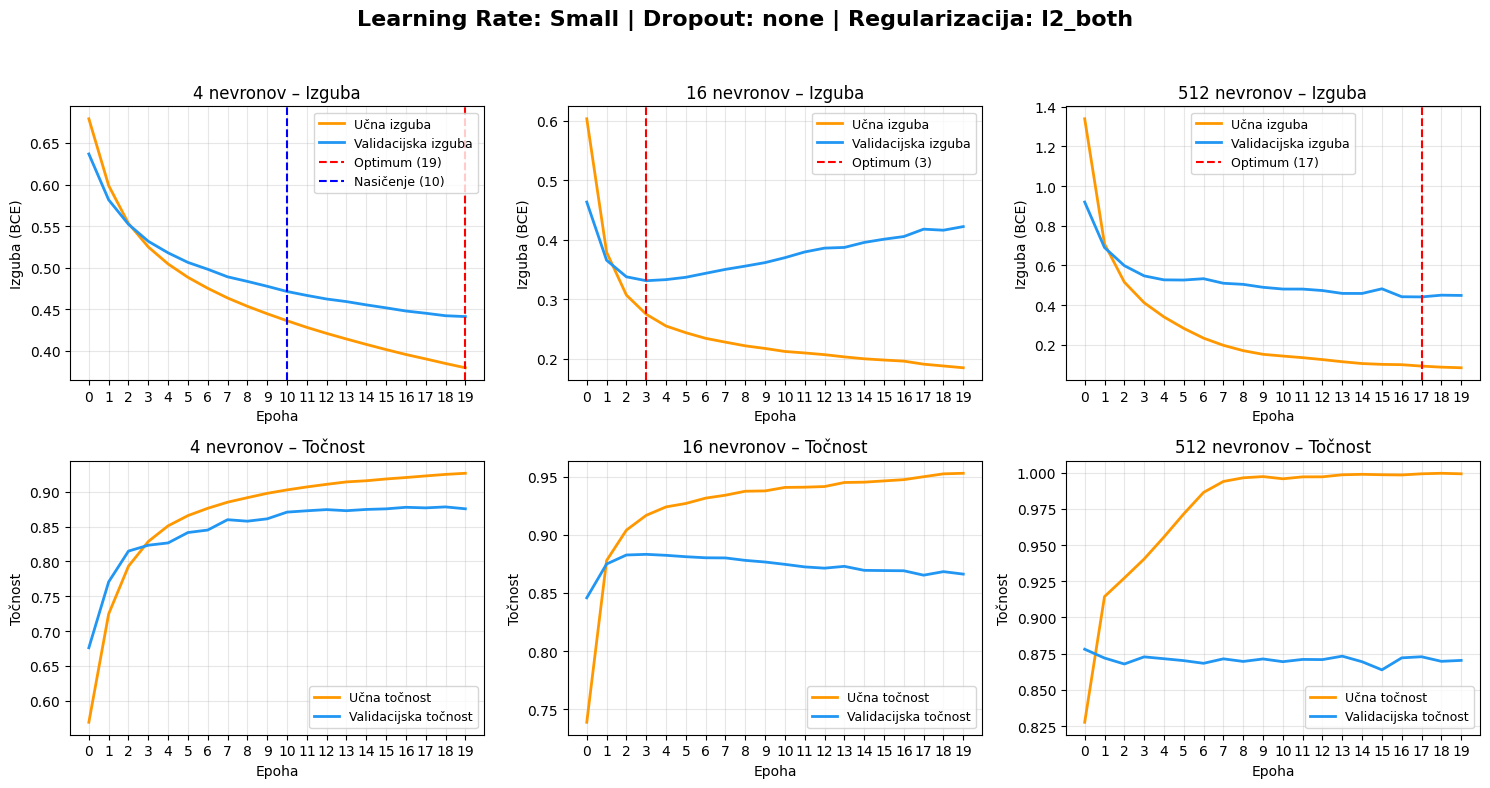

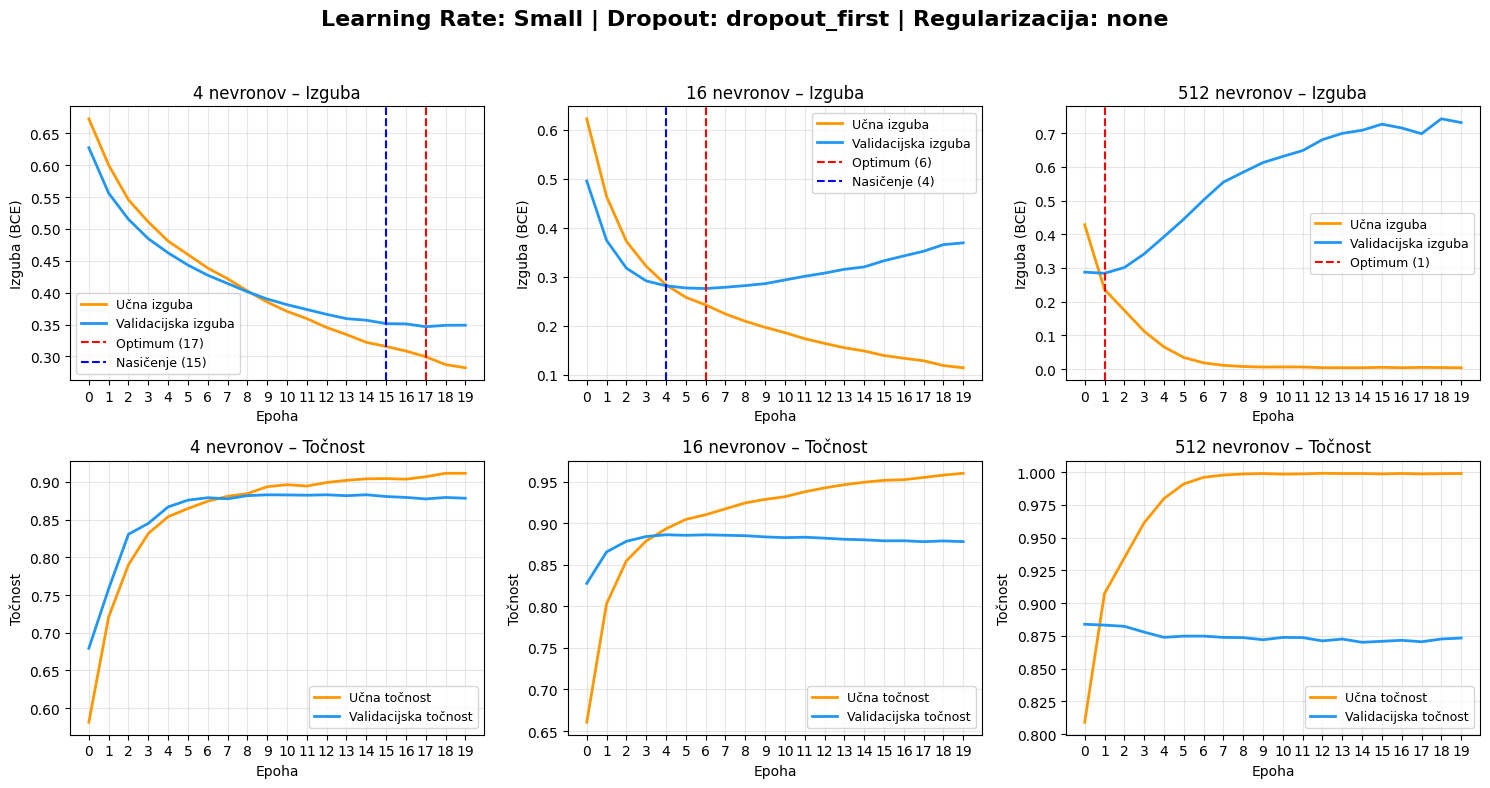

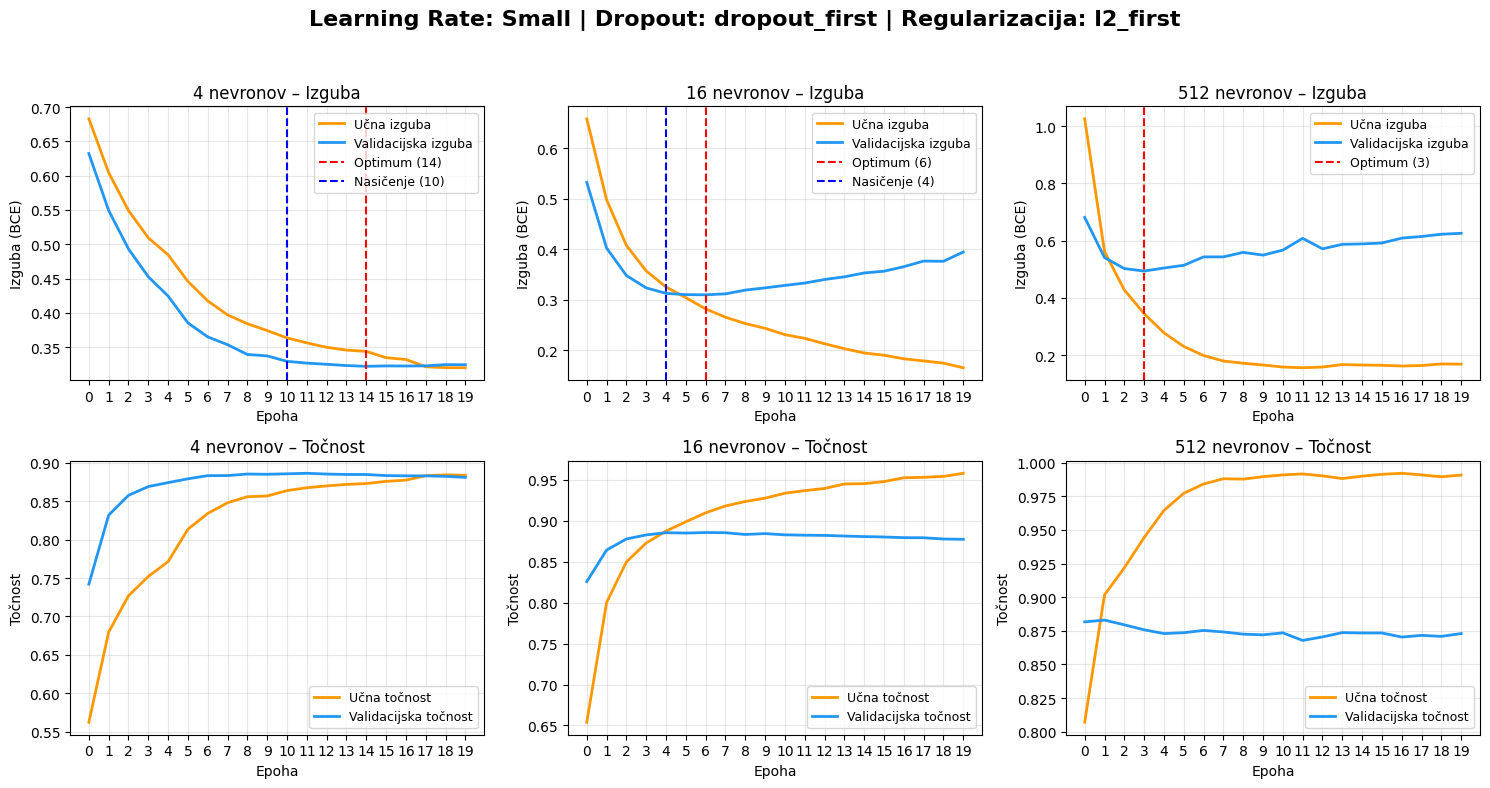

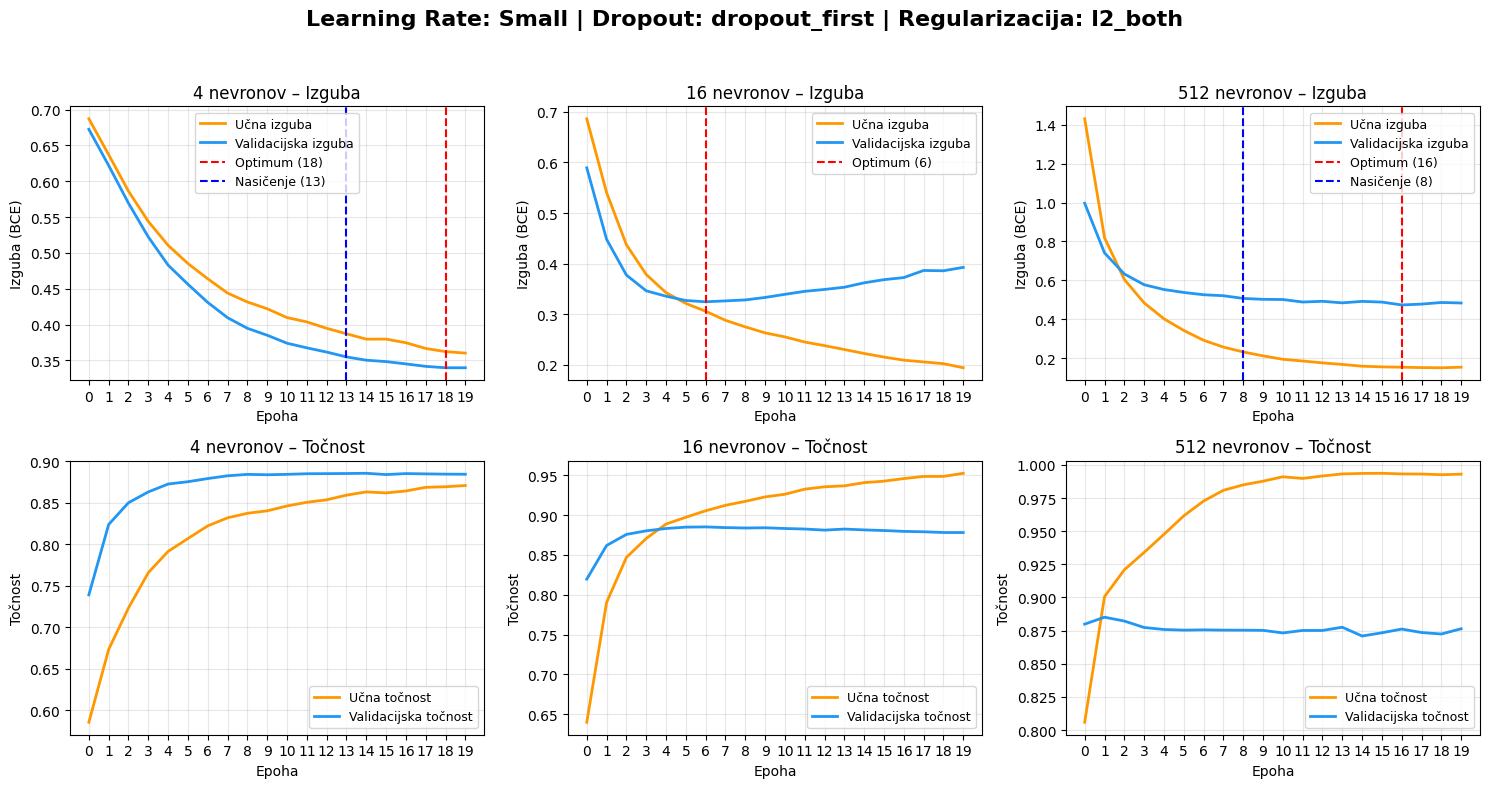

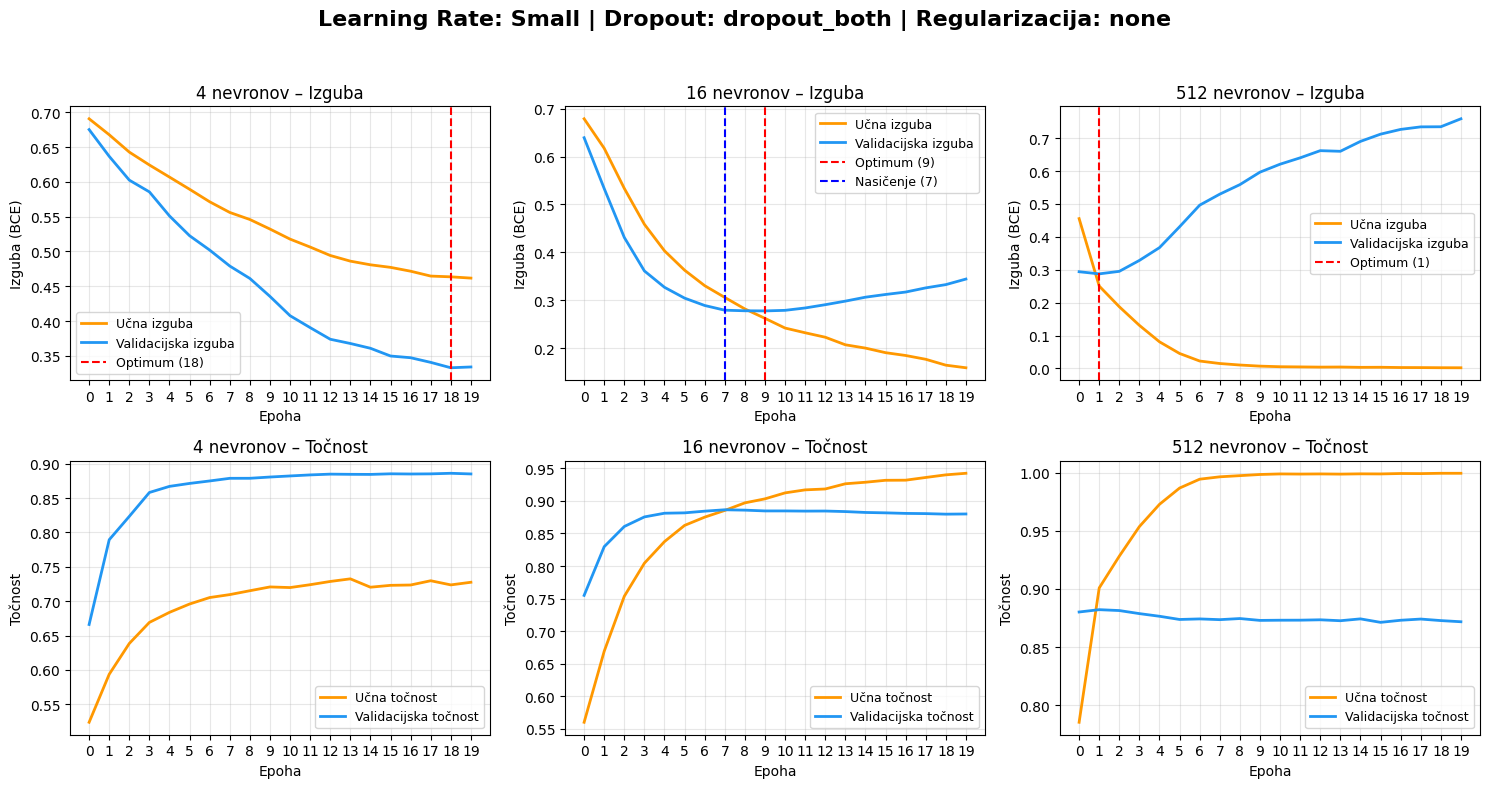

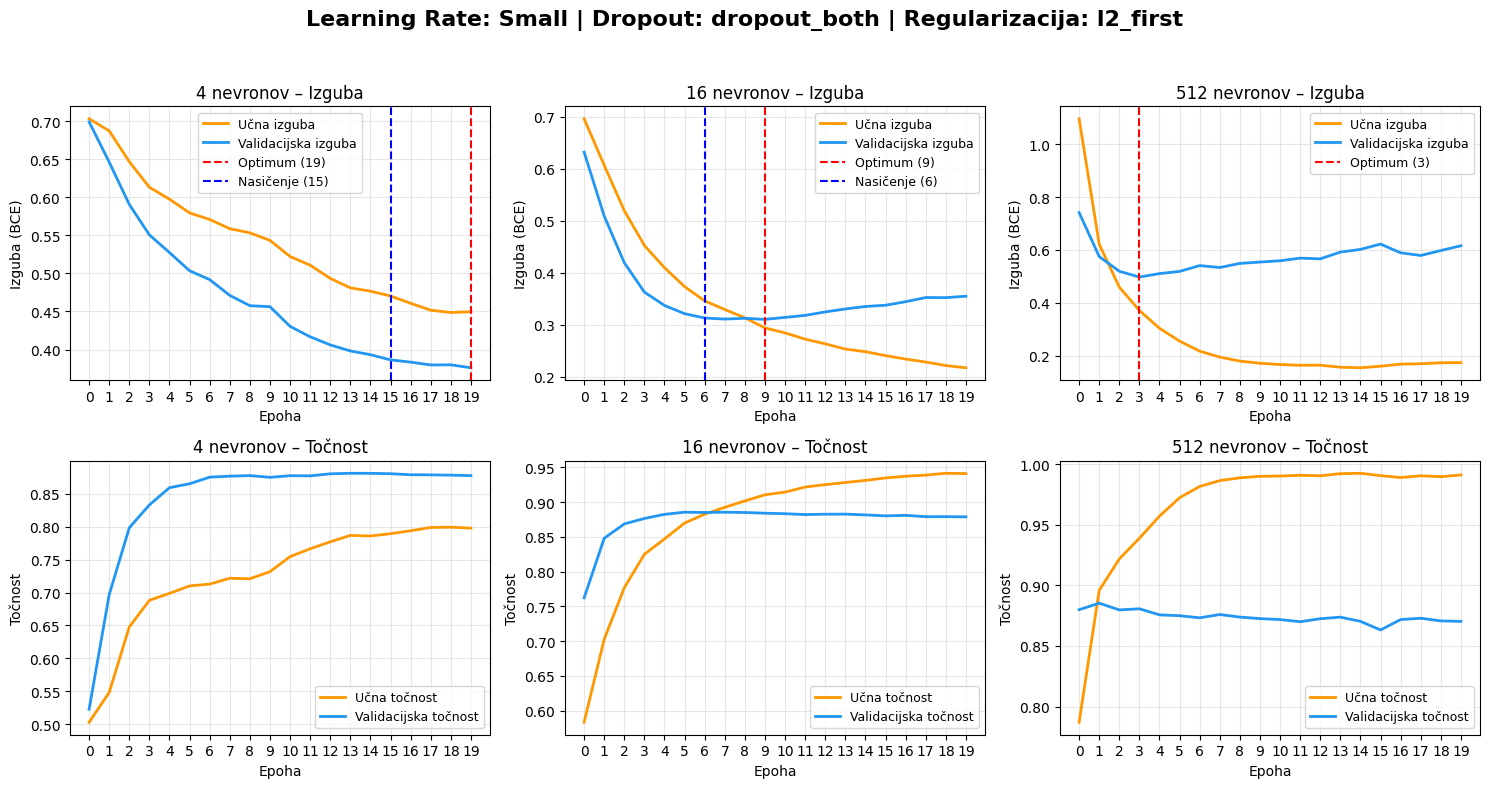

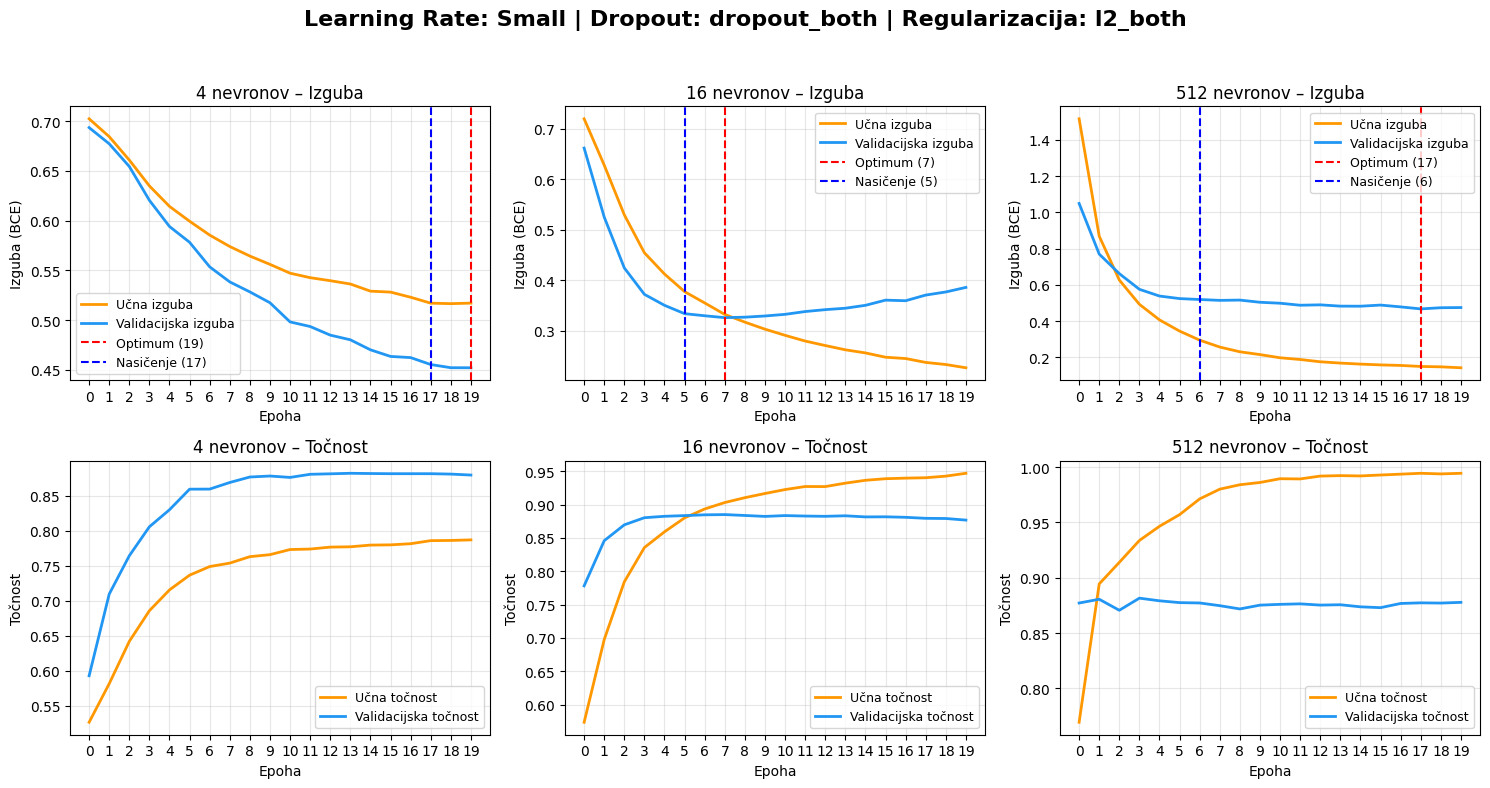

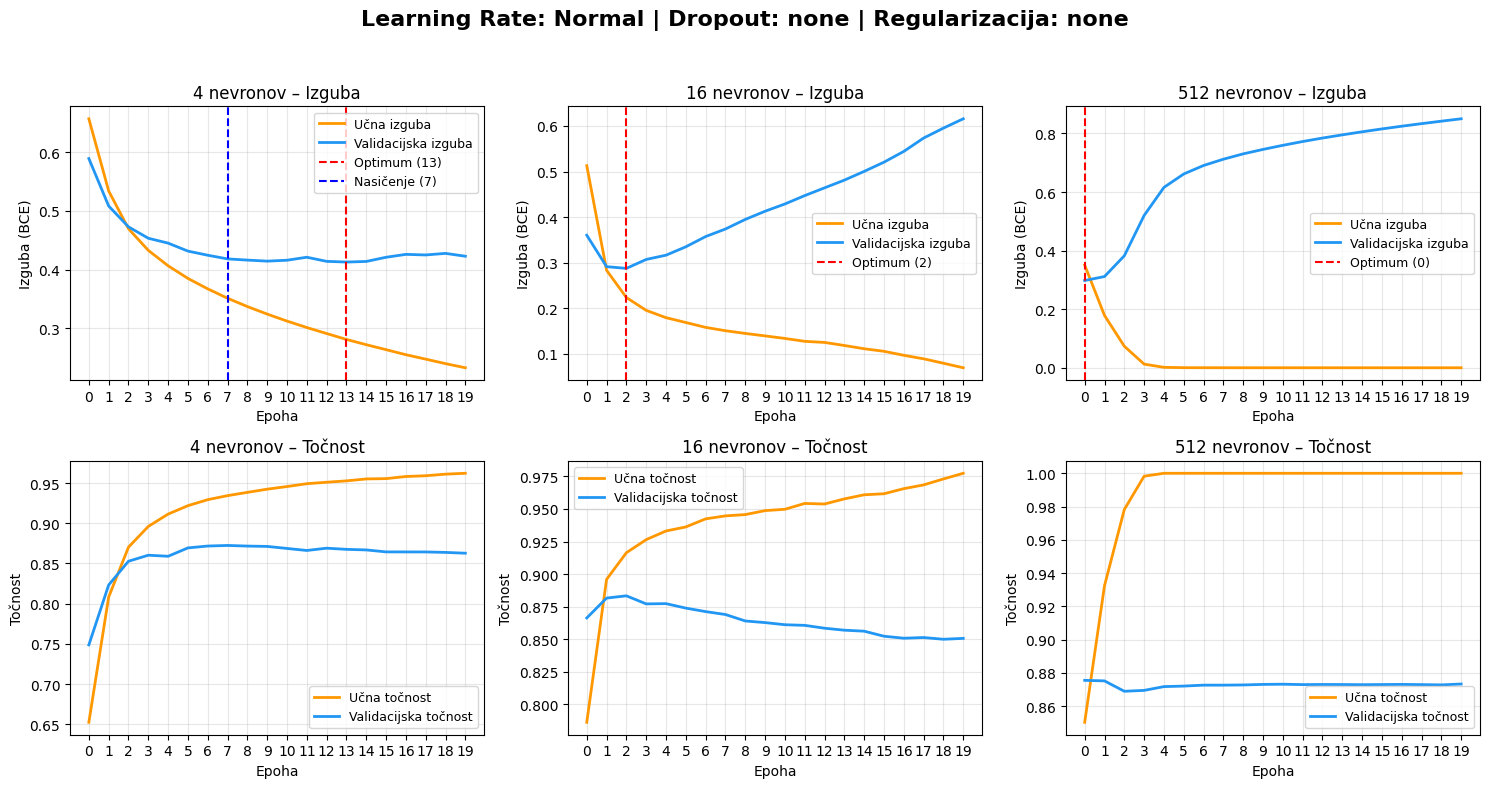

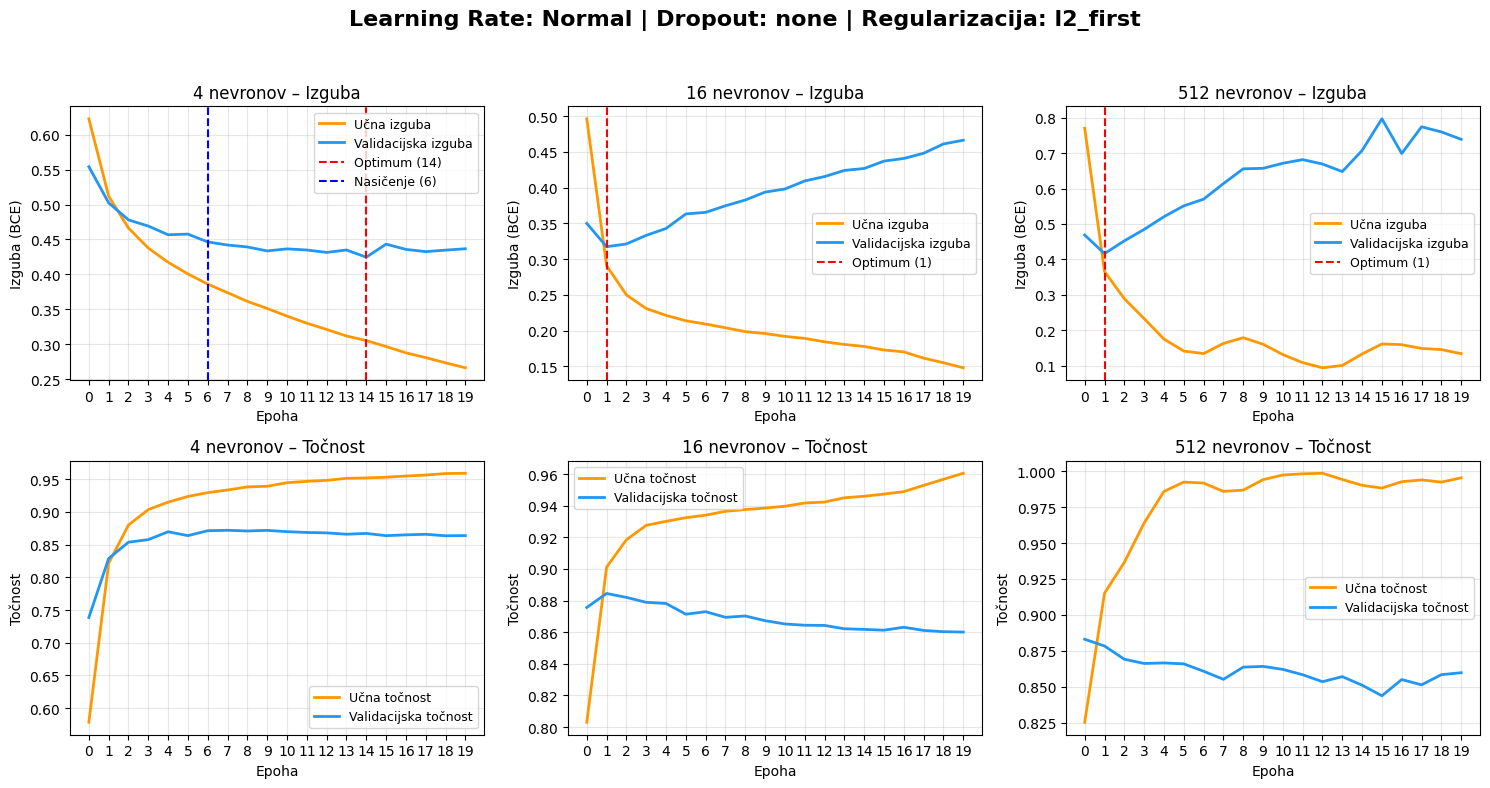

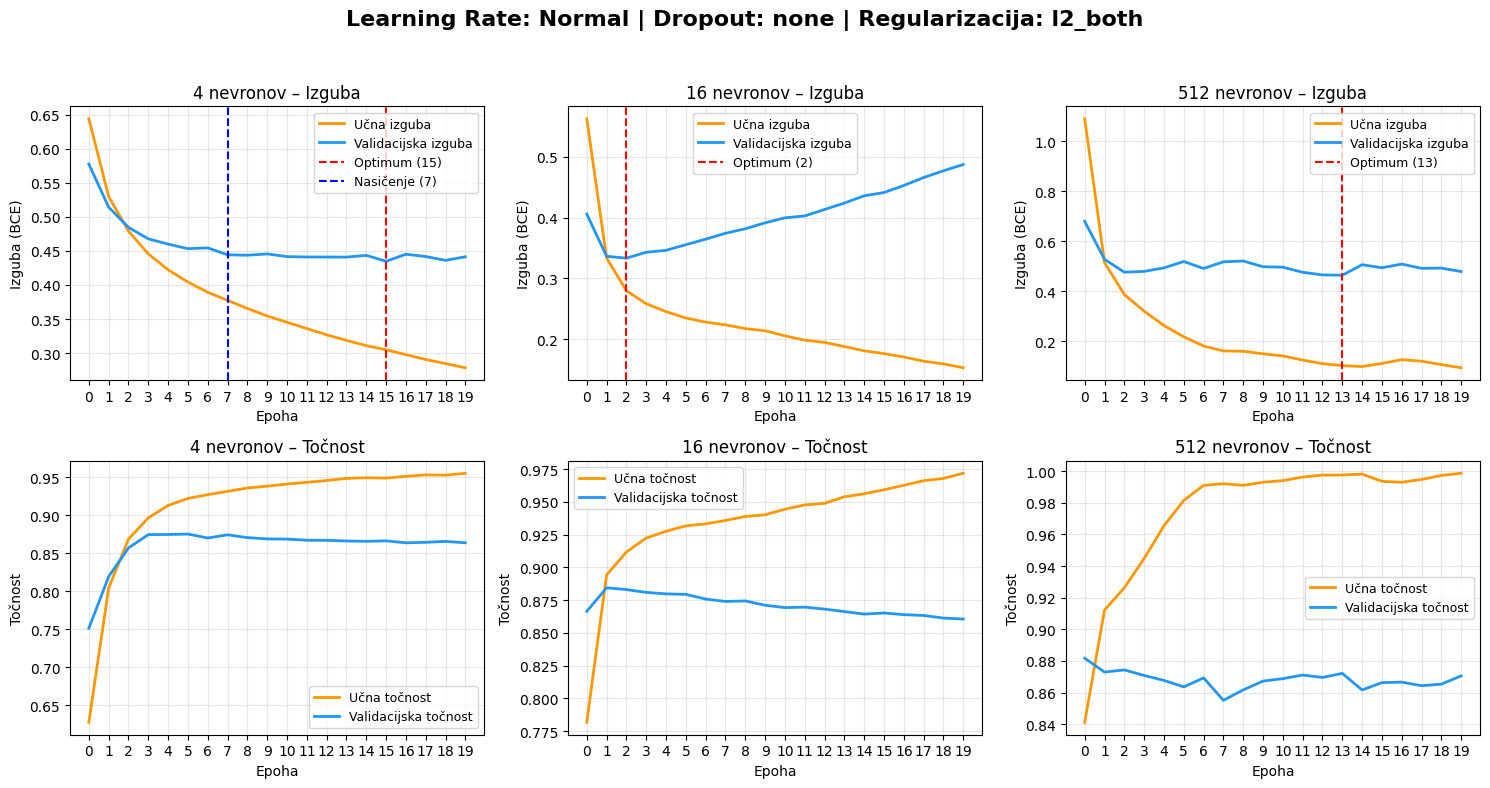

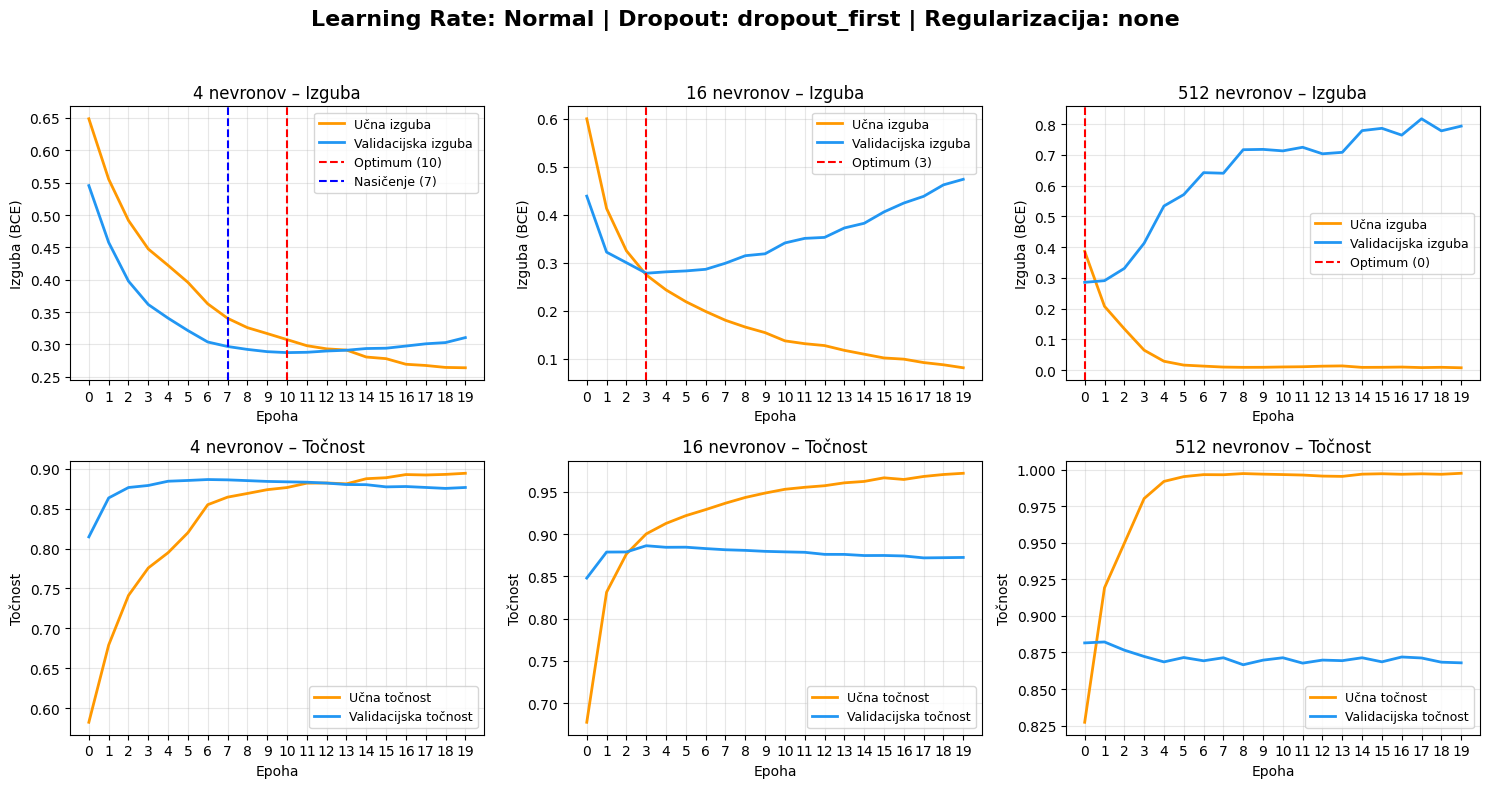

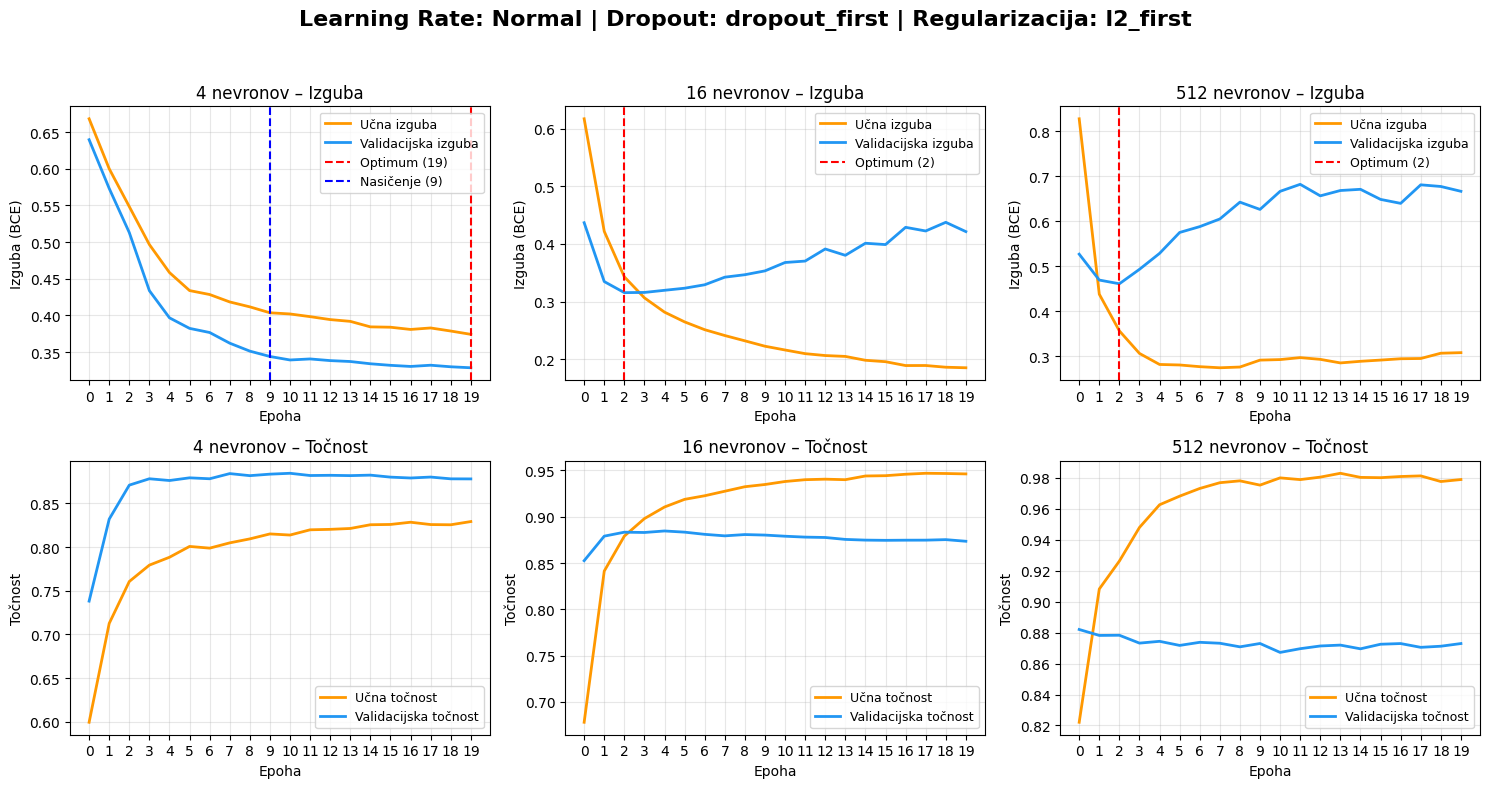

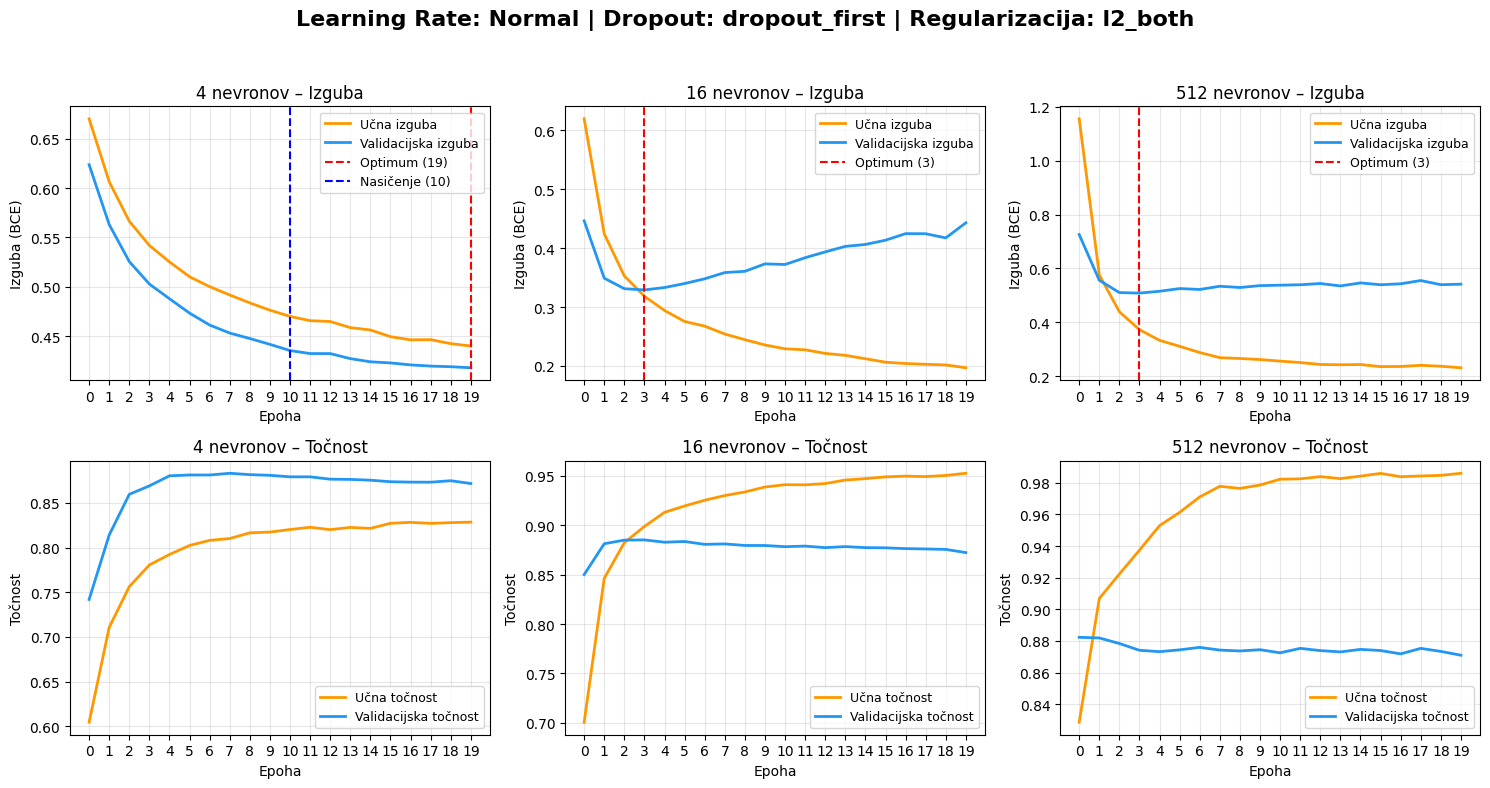

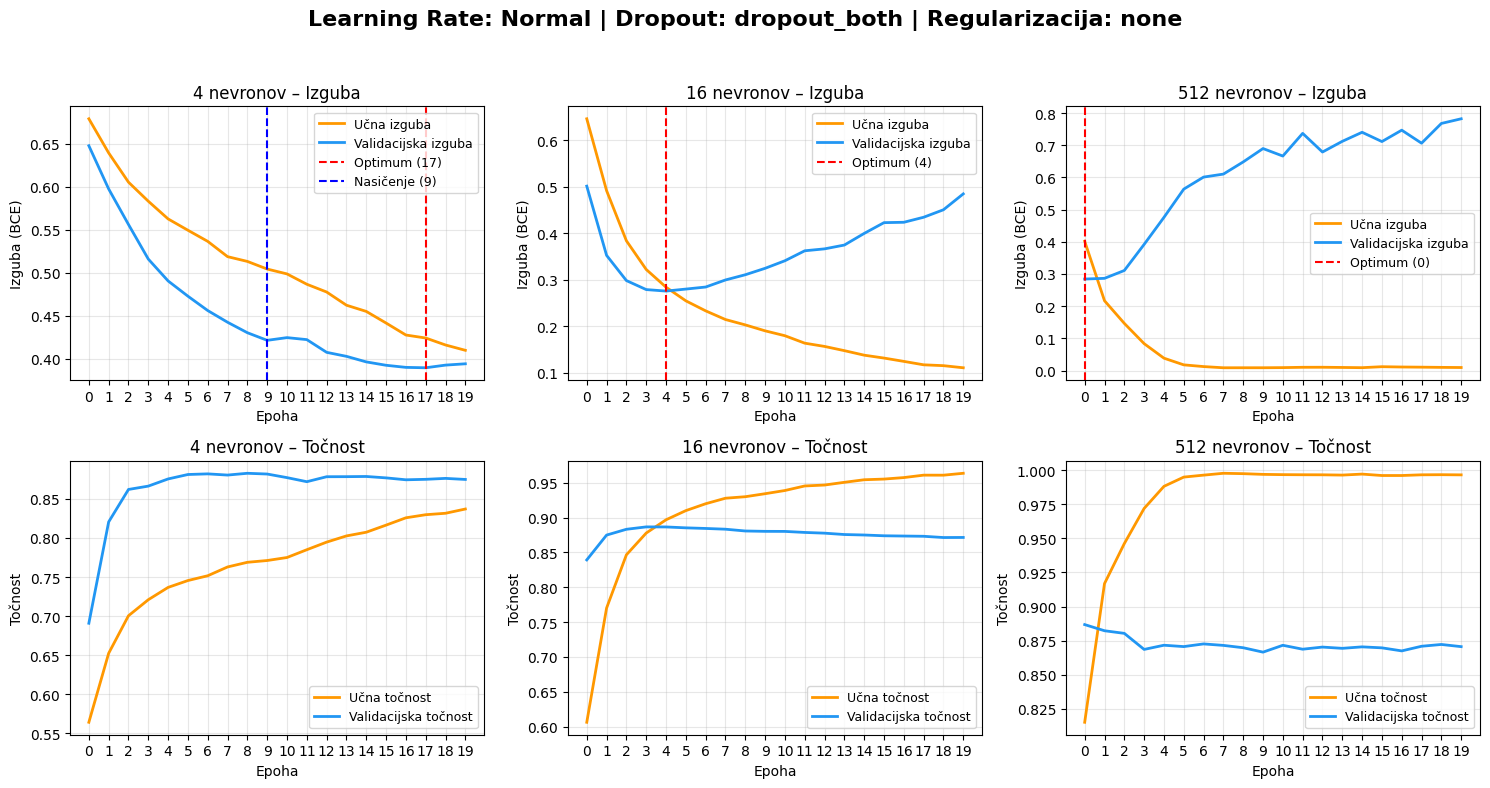

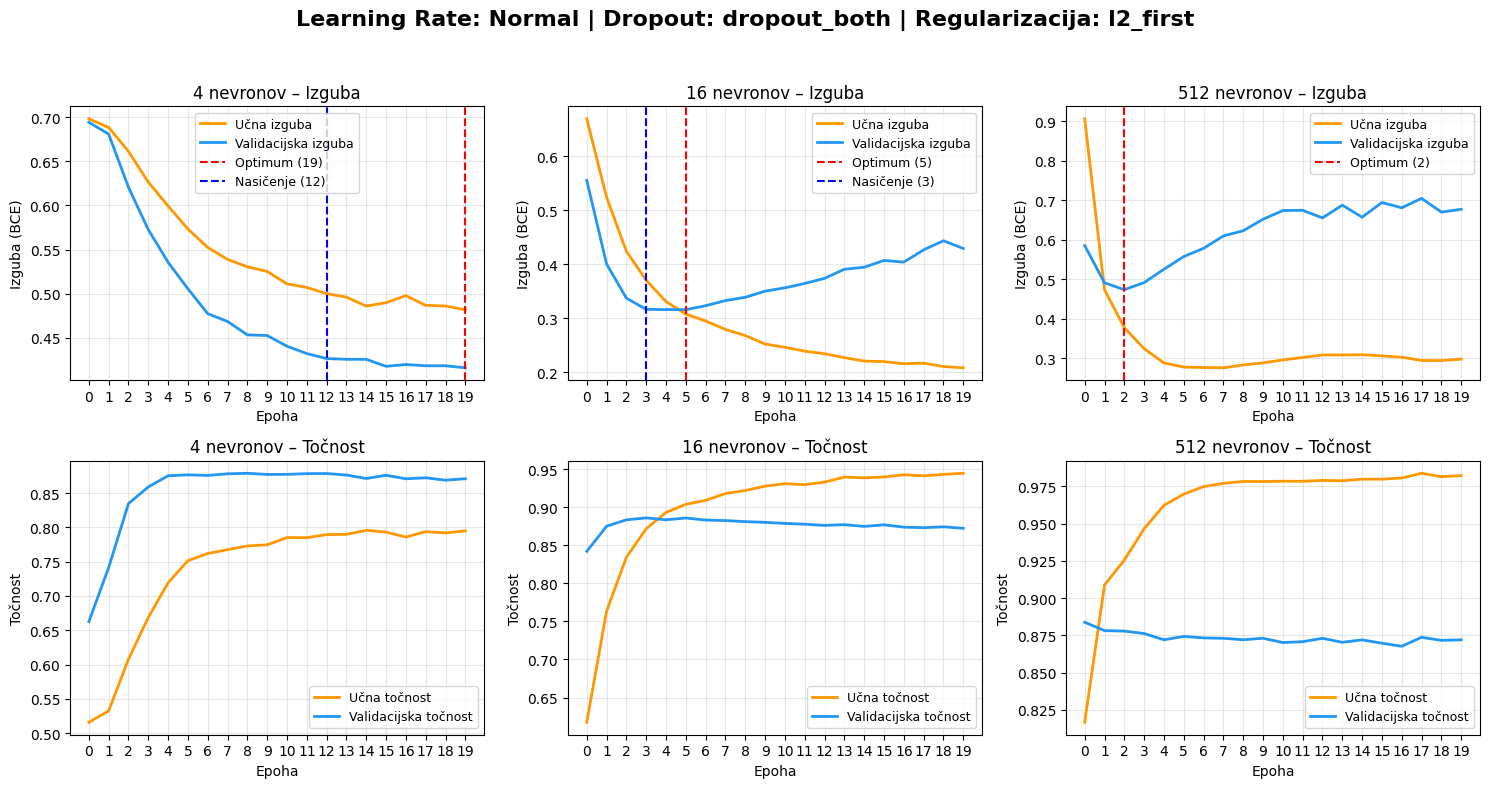

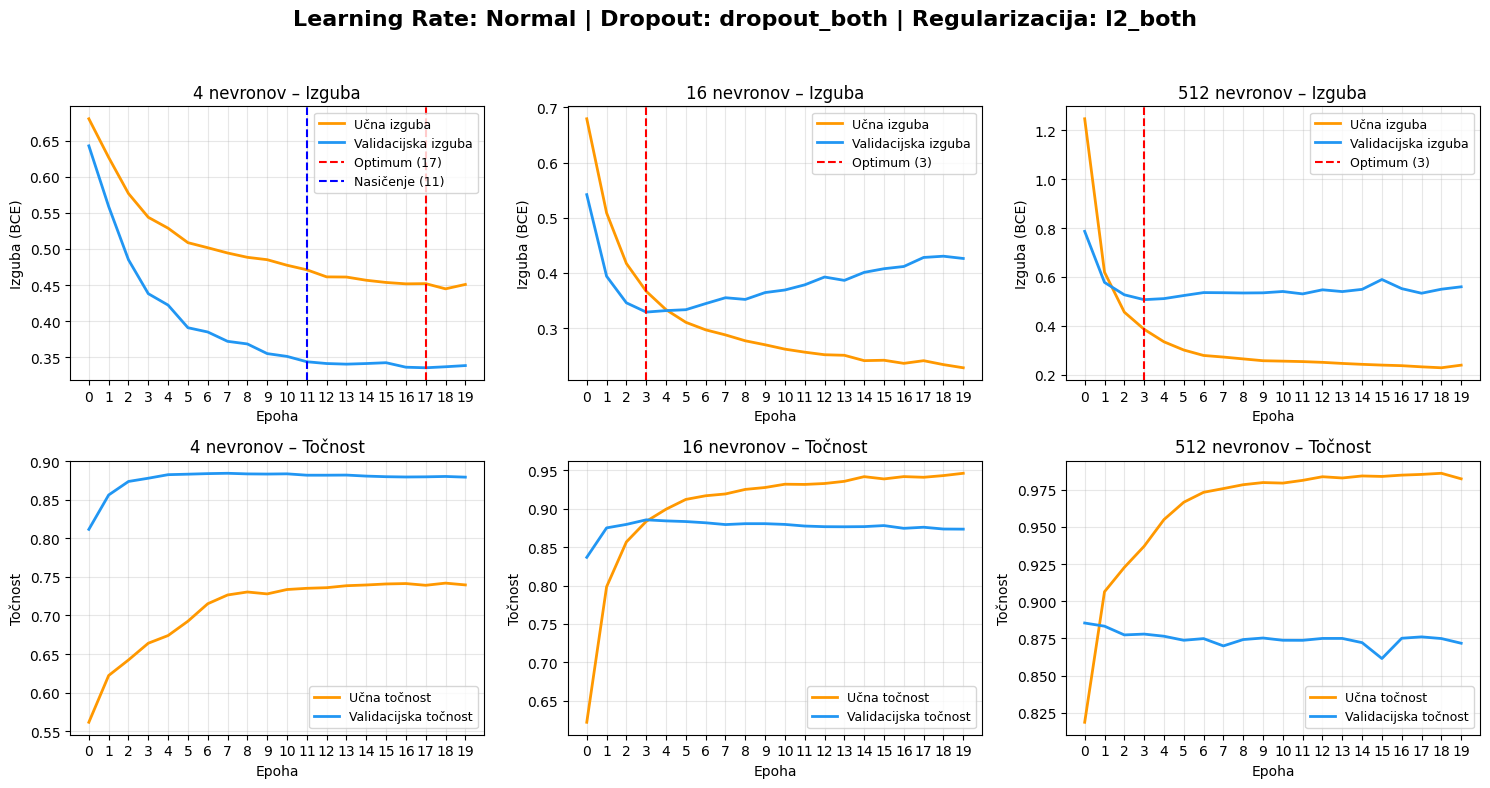

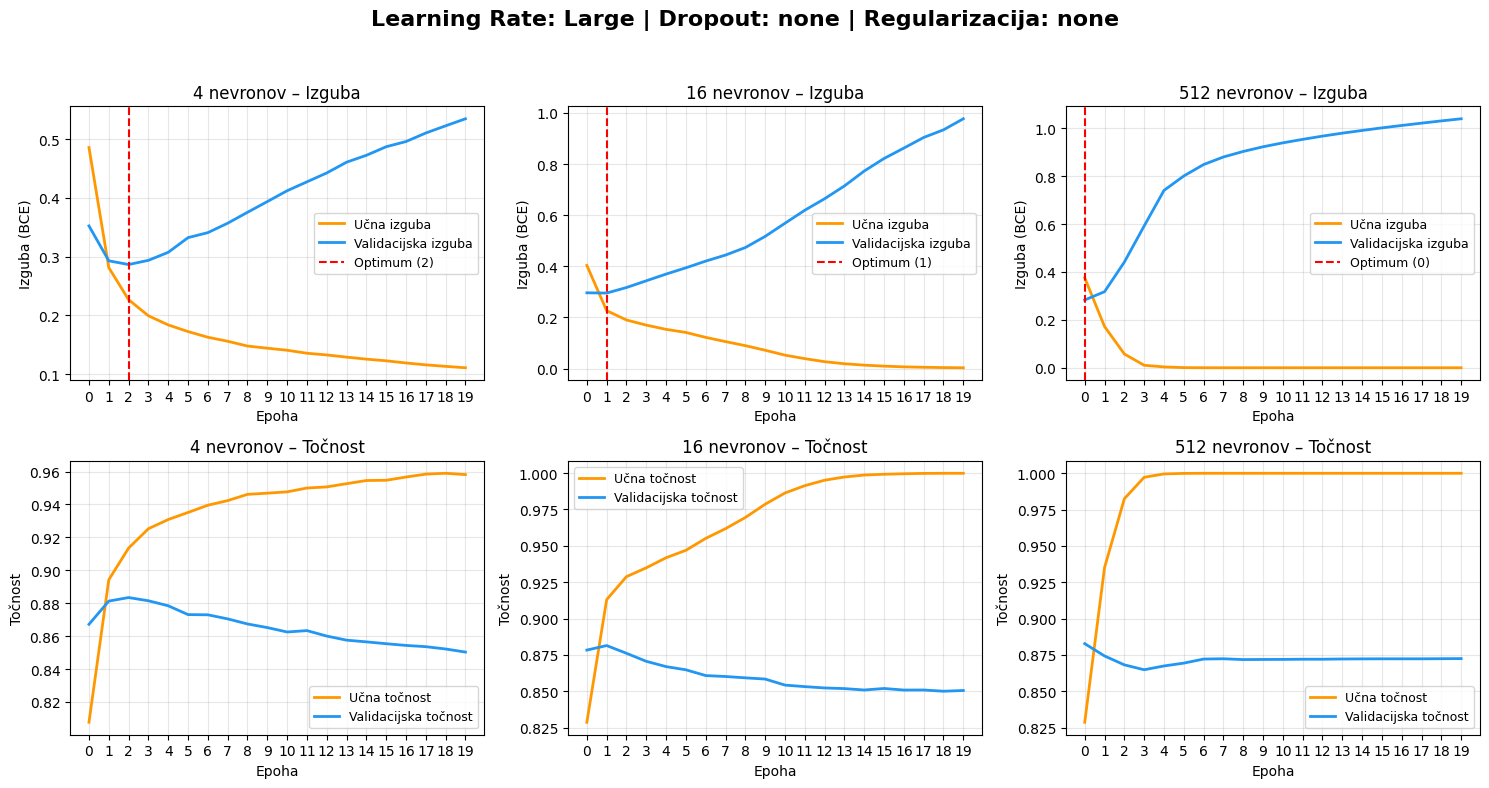

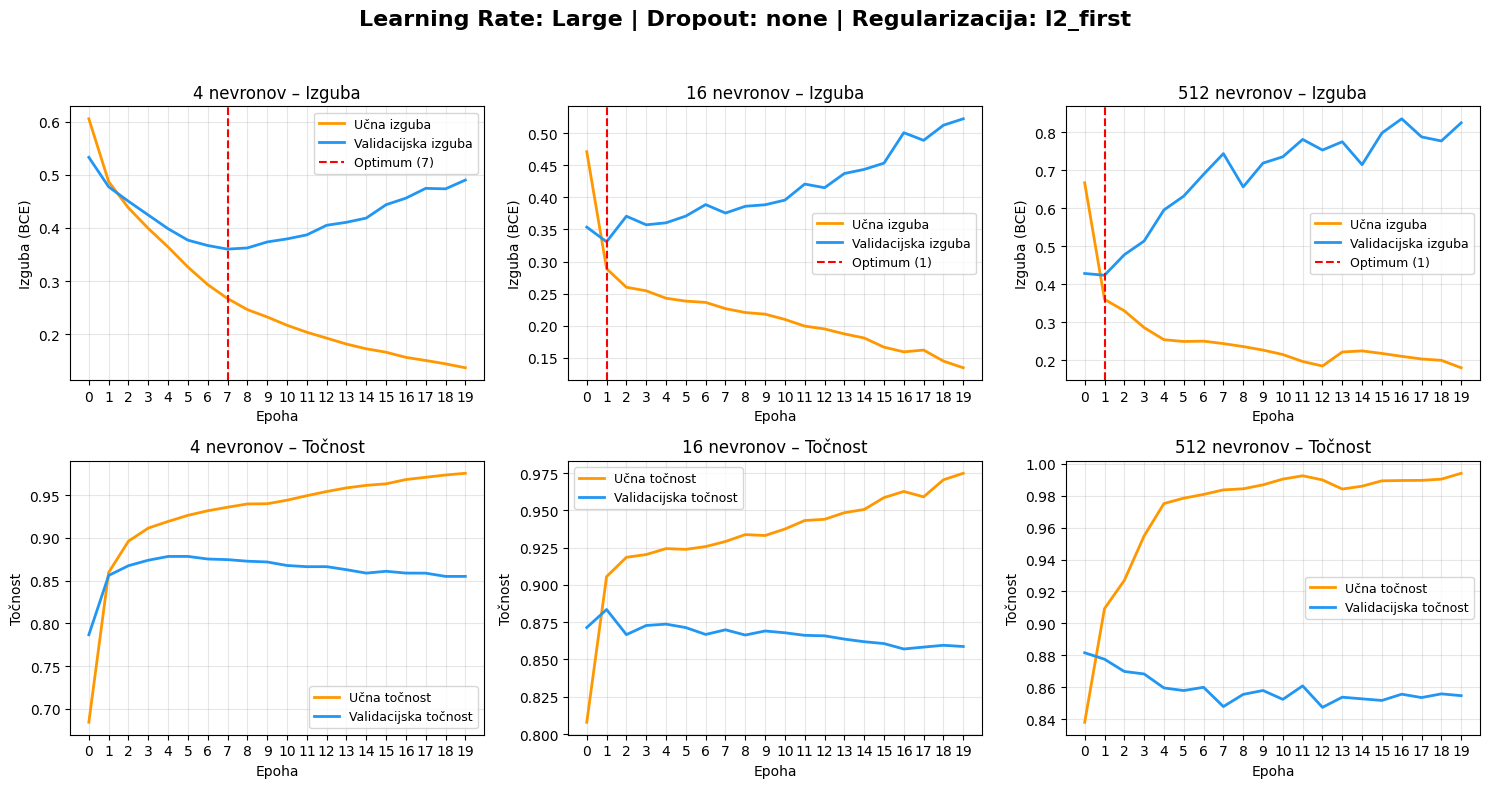

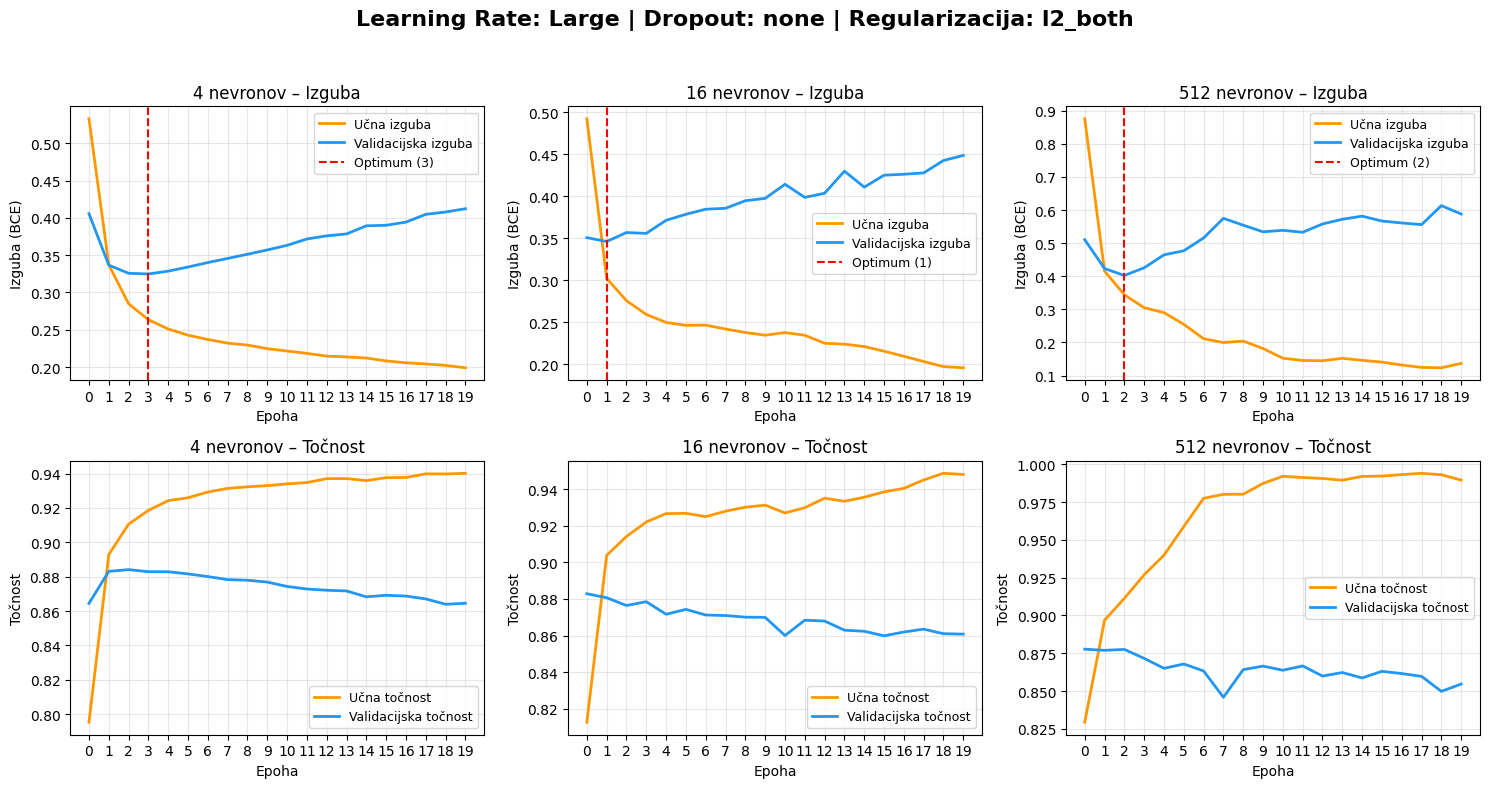

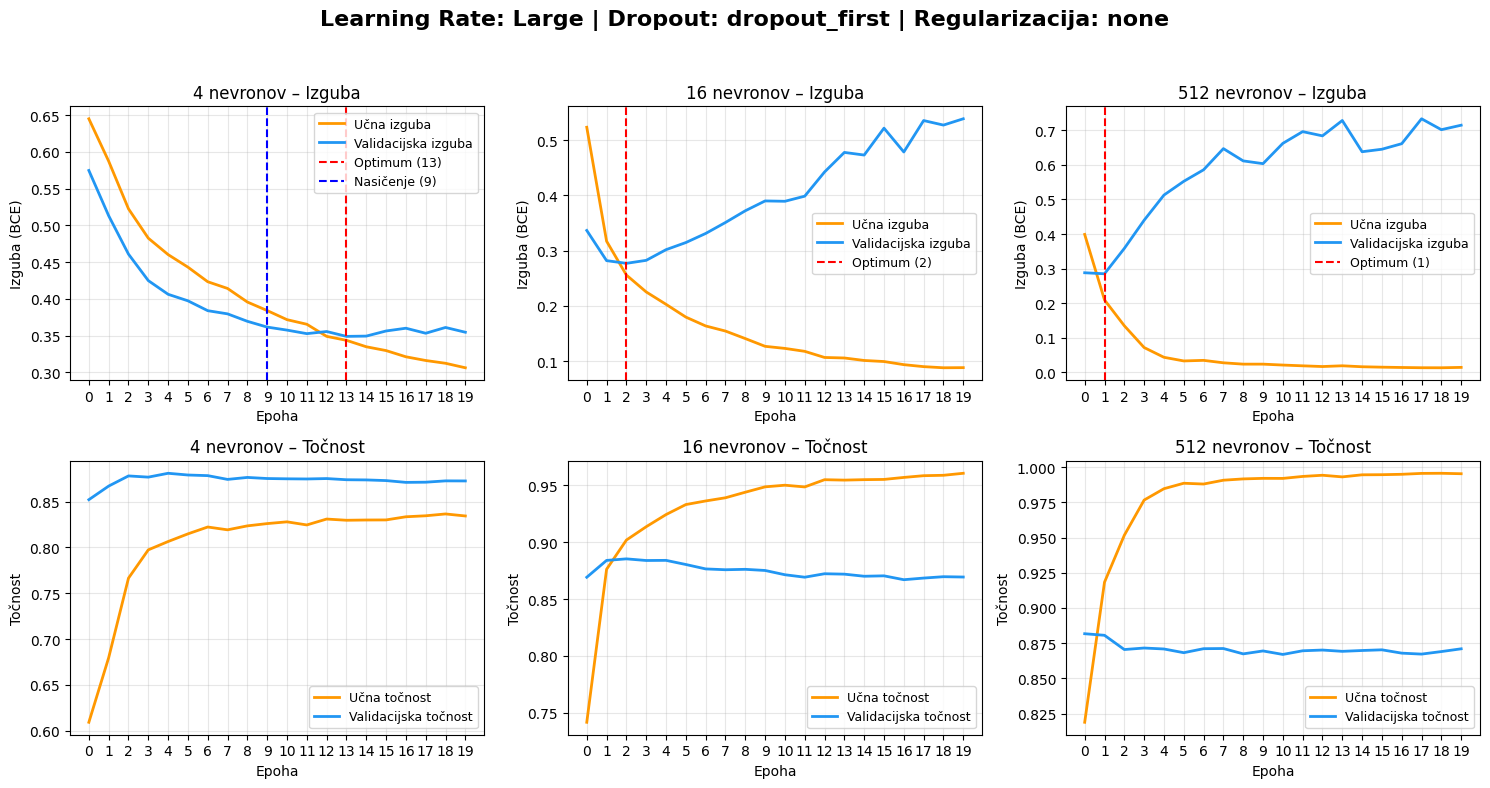

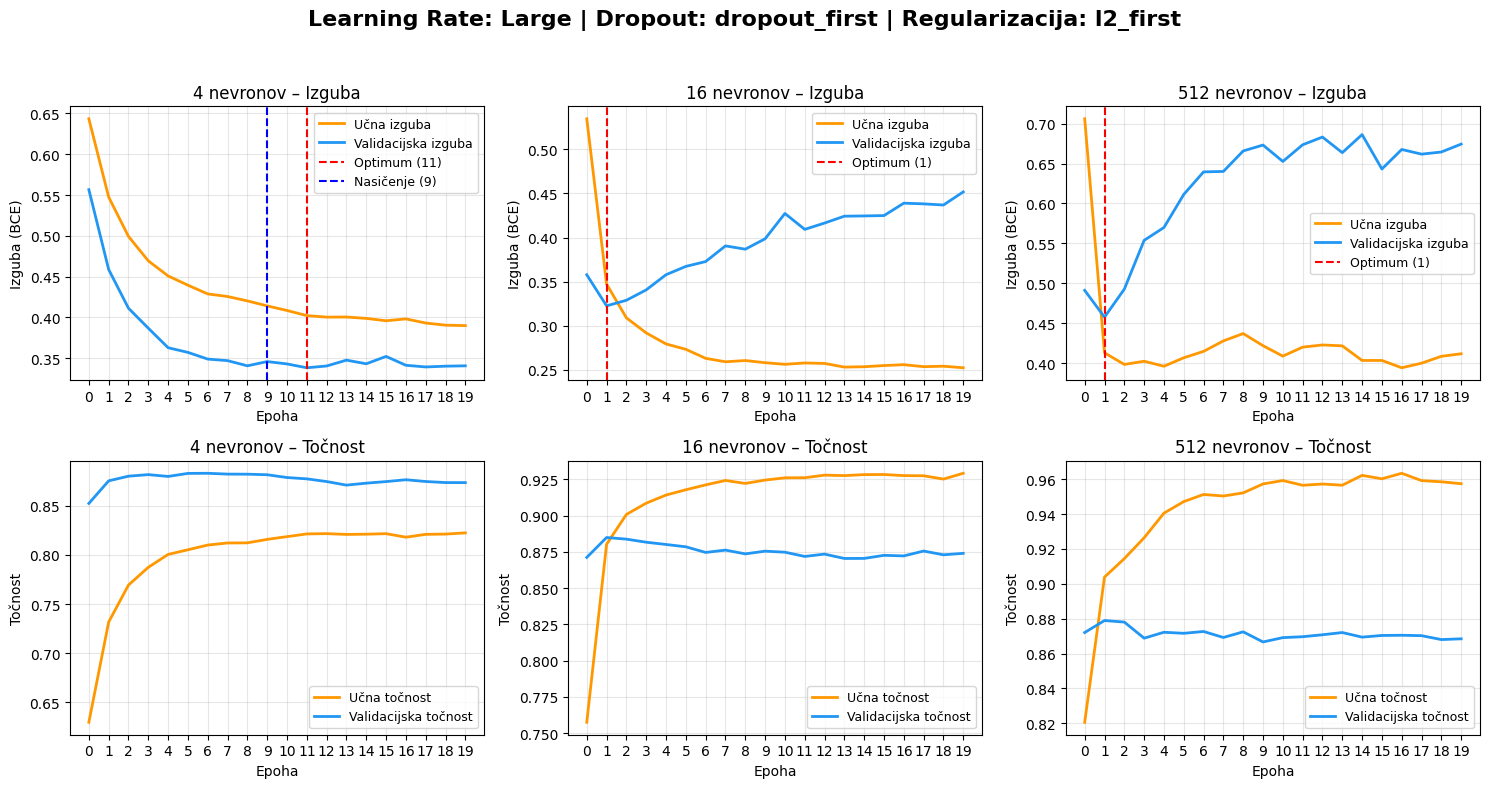

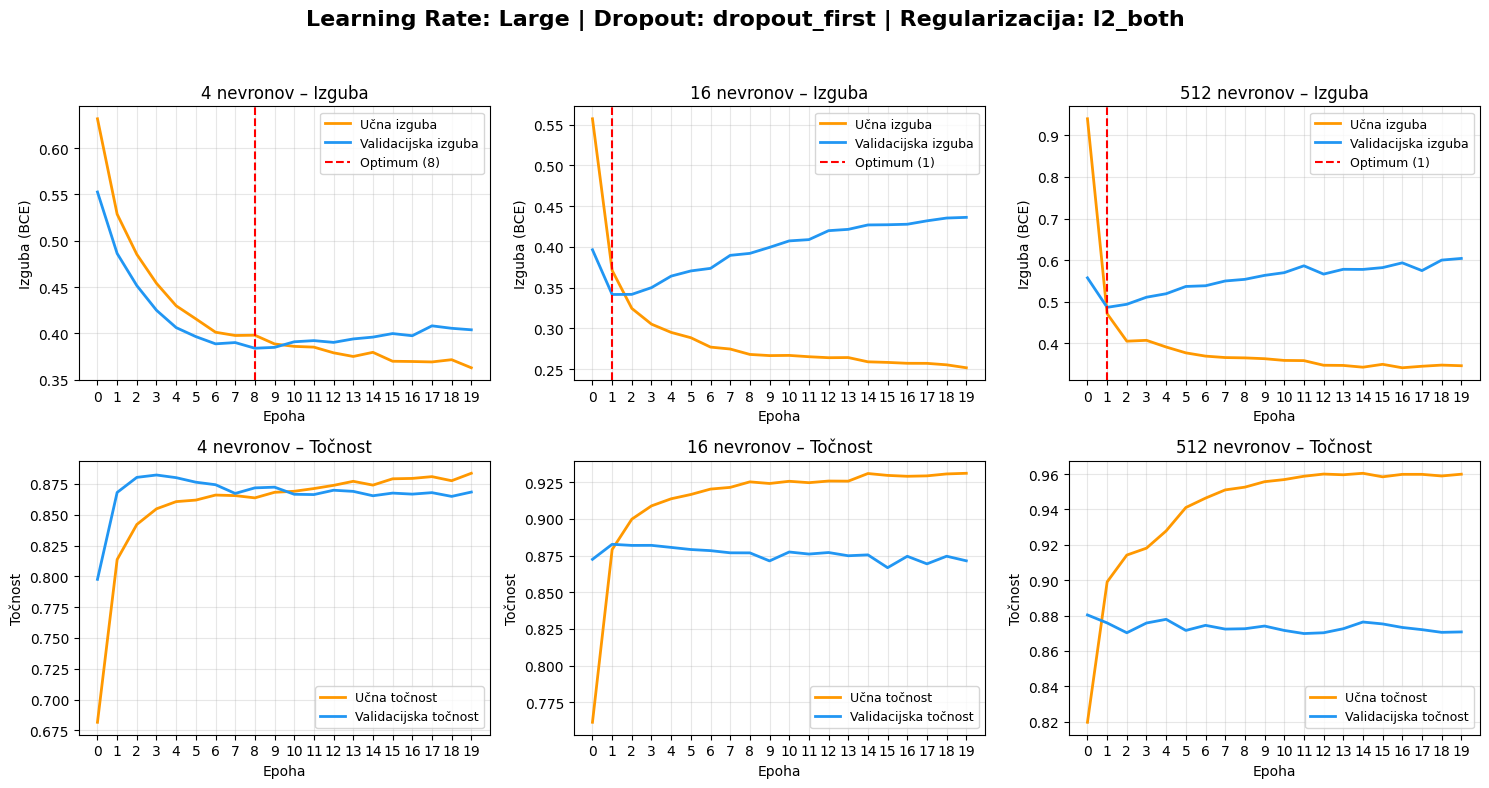

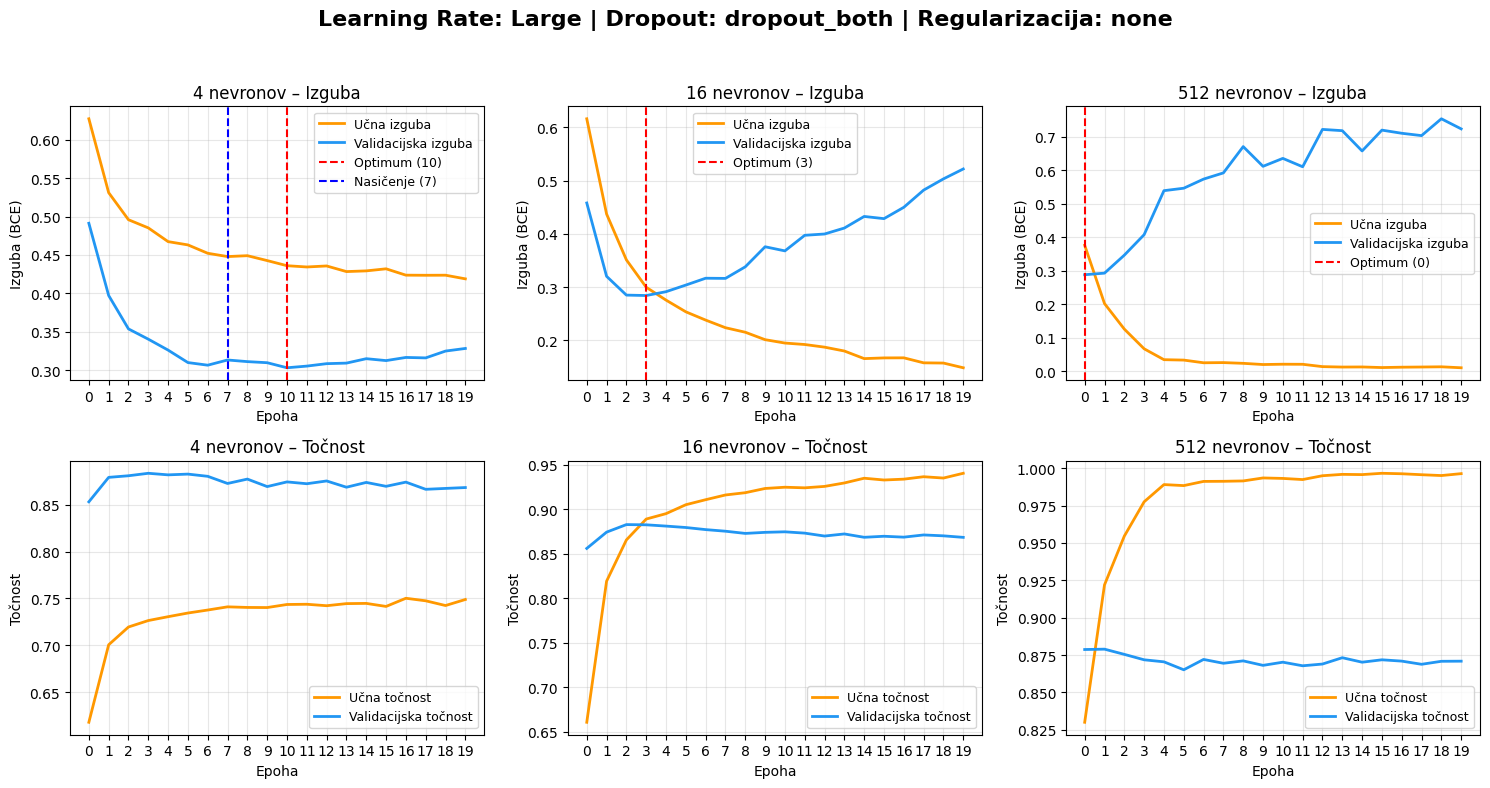

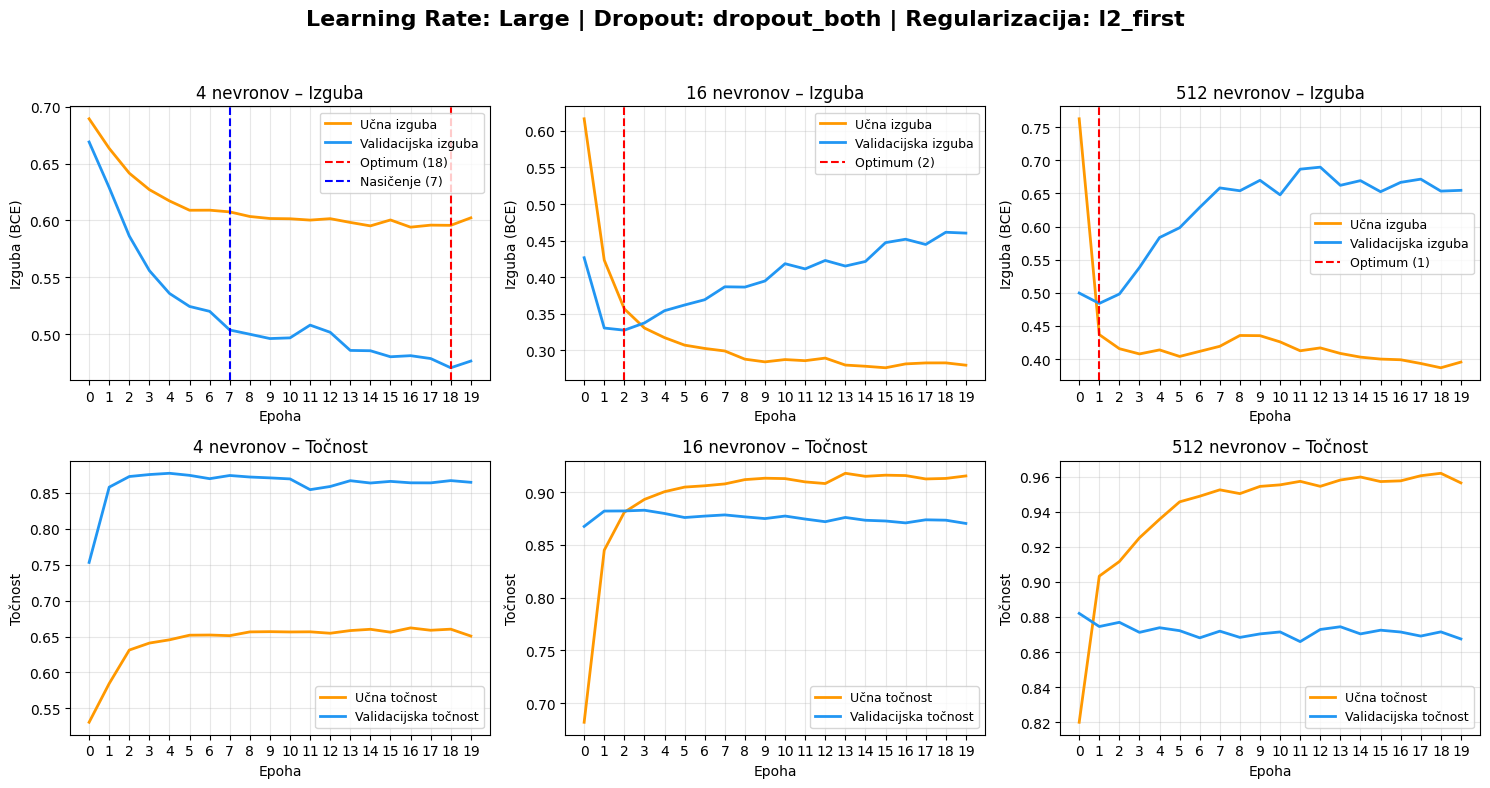

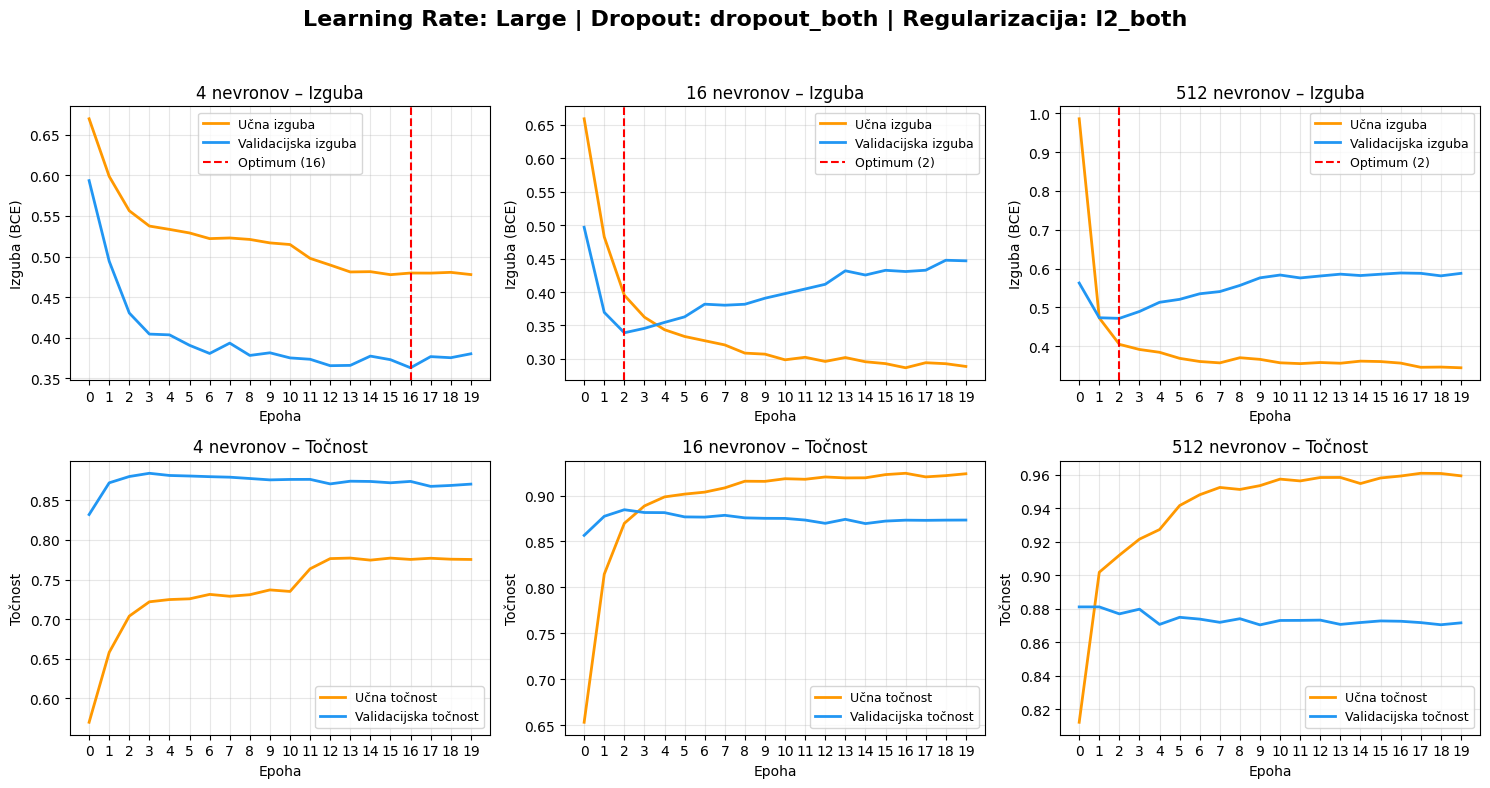

In [6]:
import matplotlib.pyplot as plt

for lr_name, lr_results in results.items():
    for drop_mode, reg_results in lr_results.items():
        for reg_mode, neuron_results in reg_results.items():
            fig, axes = plt.subplots(2, len(num_neurons), figsize=(5 * len(num_neurons), 8))
            fig.suptitle(f"Learning Rate: {lr_name} | Dropout: {drop_mode} | Regularizacija: {reg_mode}", fontsize=16, fontweight='bold')

            for j, n in enumerate(num_neurons):
                info = neuron_results[n]
                hist = info['history']
                best_epoch = info['best_epoch']
                plateau_epoch = info['plateau_epoch']

                # --- 1. vrstica: Izguba ---
                ax_loss = axes[0, j]
                ax_loss.plot(hist.history['loss'], label='Učna izguba', color='#FF9800', linewidth=2)
                ax_loss.plot(hist.history['val_loss'], label='Validacijska izguba', color='#2196F3', linewidth=2)
                ax_loss.axvline(best_epoch, color='r', linestyle='--', linewidth=1.5, label=f'Optimum ({best_epoch})')
                if plateau_epoch is not None:
                    ax_loss.axvline(plateau_epoch, color='b', linestyle='--', linewidth=1.5,
                                    label=f'Nasičenje ({plateau_epoch})')
                ax_loss.set_title(f'{n} nevronov – Izguba', fontsize=12)
                ax_loss.set_xlabel('Epoha')
                ax_loss.set_ylabel('Izguba (BCE)')
                ax_loss.set_xticks(range(EPOCHS))
                ax_loss.legend(fontsize=9)
                ax_loss.grid(alpha=0.3)

                # --- 2. vrstica: Točnost ---
                ax_acc = axes[1, j]
                ax_acc.plot(hist.history['accuracy'], label='Učna točnost', color='#FF9800', linewidth=2)
                ax_acc.plot(hist.history['val_accuracy'], label='Validacijska točnost', color='#2196F3', linewidth=2)
                ax_acc.set_title(f'{n} nevronov – Točnost', fontsize=12)
                ax_acc.set_xlabel('Epoha')
                ax_acc.set_ylabel('Točnost')
                ax_acc.set_xticks(range(EPOCHS))
                ax_acc.legend(fontsize=9)
                ax_acc.grid(alpha=0.3)

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()


In [8]:
all_models = []

for lr_name, lr_results in results.items():
    for dropout_mode, reg_results in lr_results.items():
        for reg_mode, neuron_results in reg_results.items():
            for n, info in neuron_results.items():
                hist = info['history']
                best_epoch = info.get('best_epoch', -1)
                if best_epoch >= 0:
                    val_acc_best = hist.history['val_accuracy'][best_epoch]
                    all_models.append({
                        'learning_rate': lr_name,
                        'dropout': dropout_mode,
                        'regularization': reg_mode,
                        'neurons': n,
                        'val_accuracy': val_acc_best
                    })

top = sorted(all_models, key=lambda x: x['val_accuracy'], reverse=True)[:5]

print("🏆 Top 5 modeli po validacijski točnosti:\n")
for i, m in enumerate(top, 1):
    print(f"{i}. LR: {m['learning_rate']}, Dropout: {m['dropout']}, "
          f"Regularization: {m['regularization']}, Neurons: {m['neurons']}, "
          f"Val Accuracy: {m['val_accuracy']:.4f}")

🏆 Top 5 modeli po validacijski točnosti:

1. LR: Normal, Dropout: dropout_both, Regularization: none, Neurons: 512, Val Accuracy: 0.8867
2. LR: Normal, Dropout: dropout_both, Regularization: none, Neurons: 16, Val Accuracy: 0.8867
3. LR: Normal, Dropout: dropout_first, Regularization: none, Neurons: 16, Val Accuracy: 0.8862
4. LR: Small, Dropout: dropout_both, Regularization: none, Neurons: 4, Val Accuracy: 0.8860
5. LR: Normal, Dropout: dropout_both, Regularization: l2_first, Neurons: 16, Val Accuracy: 0.8860


### V1.1
Iz grafa je razvidno, da po epochi 2 prihaja do overfittings, saj med učenjem pada izguva (ker prihaja do pomnenja vzorcev), pri validaciji pa nato ugotovimo da je prilagodljivost modela slabša.

### V1.2
S majn nevroni se model počasneje uči. To je razvino tudi v razlimi epoch med optimumom in platojom. Overfitting tudi počasneje "eskploira". Zmanjšanje modela ni nujno rešitev za overfitting.

### V1.3
Pri tej konfuguraciji modela je razvino, da je model prevelik za problem, ki ga rešujemo. Overfitting se pojavi zelo hitro, že po prvi epohi. Model ima preveč prostih parametrov in si lahko preveč natančno zapomni učne vzorce.

### V1.4
L2 in Dropout pripomoreta pri opiljenju/odpravljanju overfittinga. Pri najmanjšem modelu se overfitting odpravi.
Najboljše rezultate ao dajali modeli s 16 nevroni in L2 ali Dropout.
Njabolj stabilne nevronske mreže so vseeno bile brez L2 ali Dropout. Na grafih je razvidno, da te mreže, ki vpeljujejo te tehnike so bolj nazobčani in majn "zglajeni".

### V1.5
S povečanjem količine podatkov se rezultati niso drastično spremenili.
Stopnja učenja je vplivala na moč overfittinga. Z večjo stopnjo učenja je overfitting bolj izrazit in se pojavi prej. Najboljši rezultati so bili doseženi z normalno stopnjo učenja (0.001).
